In [0]:
from collections import OrderedDict

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import time

# Text libraries
from collections import defaultdict
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
import os
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn import metrics,preprocessing, decomposition
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

# Image libraries
import gzip
import pickle
import zipfile
from PIL import Image, ImageOps, ImageFilter
from zipfile import ZipFile
import pathlib
import cv2 as cv2

import keras
from keras import Model, optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.applications.vgg16 import decode_predictions

import warnings
warnings.simplefilter('ignore')


[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Ce notebook est le projet 6 du parcours Data Scientist. Ce projet consiste en l'étude de la classification de biens de consommations, par l'utilisation de texte et d'images.

<h2>Sommaire</h2>

Classification par utilisation de texte
1.   Initialisation des données d'intérêt
2.   Nettoyage des descriptions
3.   Classifications possibles à base du TF-IDF
4.   Classifications possibles à base du CV

Classification par utilisation d'images
1.   Initialisation des données d'intérêt
2.   Classifications possibles à base de SIFT
3.   Classifications possibles à base de Keras 

Classification combinée par utilisation de texte et d'images


In [0]:
# Data importation into the notebook
data = pd.read_csv(r'flipkart_com-ecommerce_sample_1050.csv')
print ("Dataset : imported")


Dataset : imported


# Classification par utilisation de texte

<h2>Initialisation des données d'intérêt</h2>

Nous savons déjà, avant même de fouiller les données à notre disposition, que nous avons besoin de :
- la description des produits, vu que le texte étudié sera basé essentiellement sur cela.
- la catégorie connue des produits, afin d'effectuer des comparaisons entre les catégories connues et prédites
- les noms des produits, qui seront à la fois ajoutés en complément des descriptions, et seuls comme une base pour les prédictions, vu que cet élément va fortement et forcément diriger le choix de la bonne catégorie.

Nous sélectionnons donc ces différents éléments, afin d'obtenir un élément Pandas (Dataframe).

In [0]:
print (data)
print (data.columns)


                               uniq_id            crawl_timestamp  \
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
5     893aa5ed55f7cff2eccea7758d7a86bd  2015-12-04 07:25:36 +0000   
6     f355cc1ccb08bd0d283ed979b7ee7515  2015-12-04 07:25:36 +0000   
7     dd0e3470a7e6ed76fd69c2da27721041  2015-12-04 07:25:36 +0000   
8     41384da51732c0b4df3de8f395714fbb  2015-12-04 07:25:36 +0000   
9     710ed5f2393a4b9e8823aa0029f71f93  2015-12-04 07:25:36 +0000   
10    920154acbe49d3202ed7d2ed2df1ea13  2015-12-04 07:25:36 +0000   
11    08452abdadb3db1e686b94a9c52fc7b6  2015-12-04 07:25:36 +0000   
12    1e8741b5ae27a513546c94b3f3312aee  2015-12-04 07:25:36 +0000   
13    189fa66a5fa6f08d2802a62ecf0b

In [0]:
description_data = {}
for i in range(len(data)):
    des = data.at[i, 'product_category_tree']
    cat = []
    for x in des.split(">>"):
        x = x.replace('[', '')
        x = x.replace(']', '')
        x = x.replace('"', '')
        cat.append(x)
    data.at[i, 'product_category_tree'] = cat[0]
print('{} catégories'.format(len(data['product_category_tree'].unique())))

description_data = data[['product_category_tree', 'description']]
description_data['products'] = data['product_name']
description_data['content'] = (description_data['products'] + " " +
                               description_data['description'])

print (description_data[['products', 'content', 'description']])
print (description_data.columns)


7 catégories
                                               products  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
5     Maserati Time R8851116001 Analog Watch  - For ...   
6     Camerii WM64 Elegance Analog Watch  - For Men,...   
7     T STAR UFT-TSW-005-BK-BR Analog Watch  - For Boys   
8     Alfajr WY16B Youth Digital Watch  - For Men, Boys   
9     TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...   
10    Calibro SW-125 Analog-Digital Watch  - For Men...   
11       Cartier W6701005 Analog Watch  - For Boys, Men   
12    Lois Caron LCS-4032 Analog Watch  - For Boys, Men   
13         Titan 1639SL03 Analog Watch  - For Boys, Men   
14    Srushti Art Jewelry Megnet_Led_Sport_BlackRed1...   
15    Escort E-1700-906_Blk Analog Watch  -

# <h2>Nettoyage des descriptions</h2>

Après avoir sélectionné nos variables d'intérêt dans le fichier de data, il est maintenant essentiel de nettoyer les descriptions de chaque produit, afin de n'en garder que les éléments permettant la catégorisation du produit en question.

La première étape est d'étudier la répartition des mots dans chaque description, le tout pour chaque catégorie. Aucun tri n'est pour le moment effectué et tous les mots sont conservés. Nous utilisons pour cela la fonction word_tokenize (« tokenize » = « séparer par mot ») en retirant toutes les ponctuations pour n'avoir que les éléments à caractères alpha-numériques, et en transformant toutes les majuscules en minuscules.

Au final, nous effectuons et affichons deux types de comptages :
- un comptage de mots au total
- un comptage de mots unique (une occurence de chaque mot trouvé)

Nous pouvons ainsi voir que, si le nombre de mots uniques n'est pas très élevé (<2000 mots), certains mots sont fortement répétés (entre 8000 et 16000 selon les catégories)

{'Home Furnishing ': FreqDist({'of': 305, 'cm': 188, 'in': 163, 'the': 149, 'at': 149, 'rs': 128, 'and': 110, 'cotton': 103, 'to': 89, 'pack': 88, ...}), 'Baby Care ': FreqDist({'of': 379, 'baby': 316, 's': 275, 'for': 227, 'the': 213, 'cotton': 191, 'in': 191, 'details': 174, 'girl': 165, 'fabric': 164, ...}), 'Watches ': FreqDist({'watch': 324, 'for': 305, 'only': 272, 'at': 268, 'analog': 256, 'men': 158, 'in': 153, 'rs': 140, 'on': 140, 'day': 136, ...}), 'Home Decor & Festive Needs ': FreqDist({'of': 331, 'the': 306, 'cm': 282, 'and': 257, 'for': 215, 'with': 214, 'showpiece': 204, 'in': 173, 'to': 154, 'a': 148, ...}), 'Kitchen & Dining ': FreqDist({'to': 401, 'and': 371, 'of': 324, 'mug': 323, 'the': 314, 'your': 268, 'a': 264, 'is': 213, 'it': 212, 'ceramic': 206, ...}), 'Beauty and Personal Care ': FreqDist({'of': 202, 'for': 187, 'and': 177, 'only': 167, 'flipkart': 163, 'com': 159, 'rs': 131, 'the': 130, 'products': 128, 'on': 117, ...}), 'Computers ': FreqDist({'for': 259, 

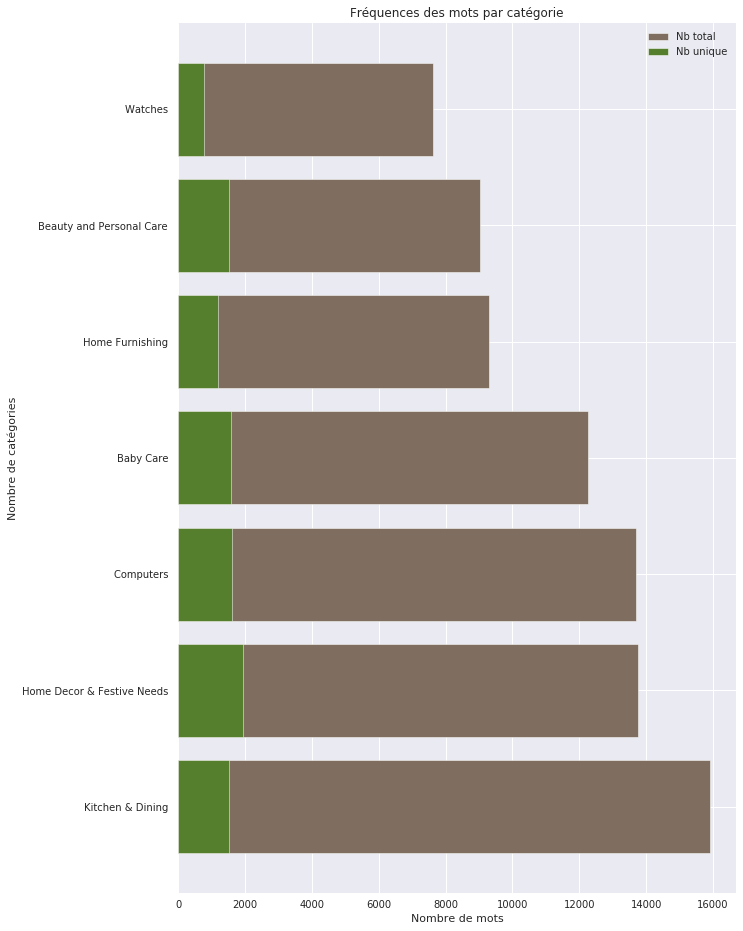

In [0]:
# Creation of token corpus by category
def creation_corpora(corpora, x):
    corpora[x["product_category_tree"]] += tokenizer.tokenize(
        x["description"].lower())


def freq_stats_corpora():
    corpora = defaultdict(list)
    description_data[["product_category_tree", 'description']].apply(
        lambda x: creation_corpora(corpora, x), axis=1)
    stats, freq = dict(), dict()
    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}

    return (freq, stats, corpora)

# Counting retrieval
tokenizer = nltk.RegexpTokenizer(r'\w+')
freq, stats, corpora = freq_stats_corpora()

print (freq)

data_stats = pd.DataFrame.from_dict(stats, orient='index')
data_stats = data_stats.sort_values(by='total', ascending=False)
data_stats_plot = data_stats.iloc[0:50]

# Frequencies display
labels = data_stats_plot.index
sizes = data_stats_plot['total']
sizes_unique = data_stats_plot['unique']

sns.set()
barWidth = 0.5
fig, ax = plt.subplots(figsize=(10, 16))
ax.barh(labels, sizes, color='#7f6d5f', linewidth=barWidth, edgecolor='white',
        label='Nb total')
ax.barh(labels, sizes_unique, color='#557f2d', linewidth=barWidth,
        edgecolor='white', label='Nb unique')
plt.legend()
plt.title("Fréquences des mots par catégorie")
plt.ylabel('Nombre de catégories')
plt.xlabel('Nombre de mots')
plt.show()


Ce premier traitement nous a indiqué qu'il va être nécessaire de retirer certains mots trop répétés. Nous récupérons donc la fréquence totale de chaque mot et en extrayons les 100 plus fréquents pour les ajouter à la liste des stopwords (mots n'apportant pas de valeur informative pour la compréhension du "sens" d'un document et corpus). Nous obtenons ainsi à la fin les descriptions sans ces stopwords, et recalculons les fréquences.

Nous avons ainsi réduit de moitié le nombre de mots uniques (environ 1000), mais aussi le nombre de mots totaux (entre 3000 et 7000). Cela reste tout de même encore assez élevé.

{'once', "isn't", 'll', 'very', 'men', 'after', 'cash', 'laptop', 'no', 'cotton', 'rs', 'we', 'she', 'until', 'm', 'about', 'these', 'those', 'himself', 'mustn', 'replacement', 'mightn', '1', 'pack', 'be', "shouldn't", 'perfect', 'analog', 'most', 'sales', 'yourself', 'any', 'him', 'they', 'buy', 'should', 'are', 'being', 'does', "wouldn't", 'from', "won't", 'off', 'few', "mustn't", 'brand', 'at', 'prices', 'whom', 'into', 'isn', '5', 'other', 'has', "couldn't", 'couldn', 'ourselves', 'nor', 'multicolor', 'own', 'cm', 'but', 'for', 'features', 'set', 'themselves', 'then', 'why', 'o', 'y', 'doesn', 'been', 'both', 'ma', 't', 'myself', 'the', "you'll", 'it', 'between', 'can', 'herself', 'wouldn', 'with', 'what', 'am', 'hadn', 'girl', 'hers', 'number', 'that', 'color', 'watch', 'aren', 'type', 'great', 'material', 'ceramic', 'too', 'all', 'quality', 'while', 'or', "needn't", 'before', "you'd", 'them', 'just', "didn't", 'weren', 'shan', 'mug', '6', "hadn't", 'day', 'you', 'guarantee', 'ain

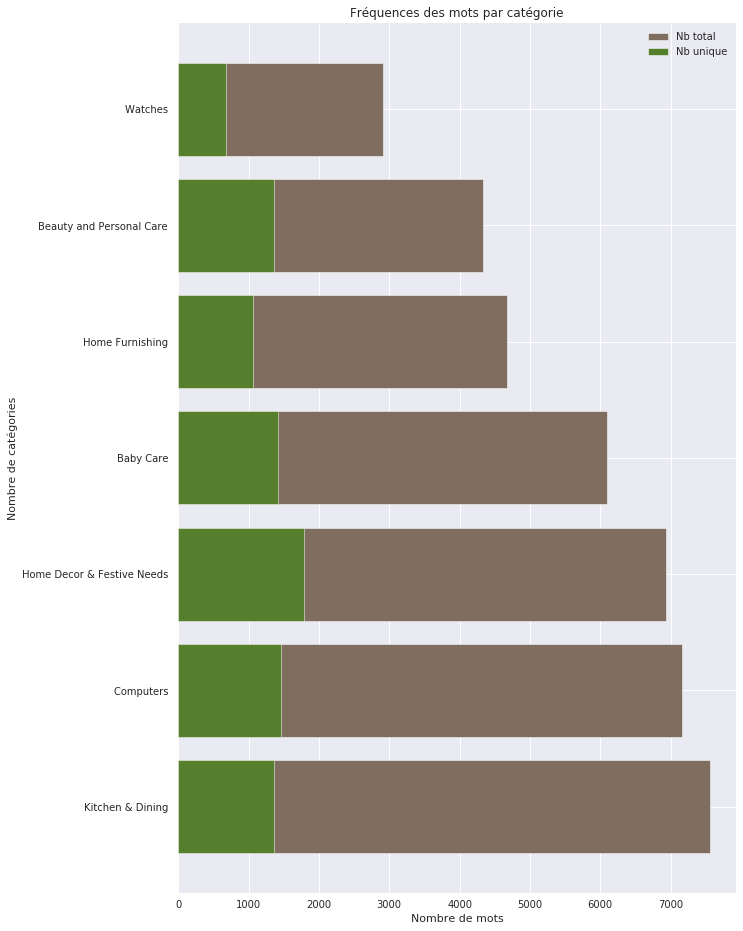

In [0]:
# Creation of token corpus by category
def creation_corpora(corpora, x):
    tokens = tokenizer.tokenize(x["description"].lower())
    corpora[x["product_category_tree"]] += [w for w in tokens
                                            if w not in list(sw)]


def freq_stats_corpora2(lookup_table=[]):
    corpora = defaultdict(list)
    description_data[["product_category_tree", 'description']].apply(
        lambda x: creation_corpora(corpora, x), axis=1)
    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}

    return (freq, stats, corpora)

# Retrieval of total frequencies of each word on all the corpus
freq_totale = nltk.Counter()
for k, v in corpora.items():
    freq_totale += freq[k]

# Arbitrary decision of number of the most frequent words to delete
most_freq = list(zip(*freq_totale.most_common(100)))[0]

# Creation of the final stopword set, with the 100 most frequent corpus words
# and all the default stopwords in NLTK library
sw = set()
sw.update(most_freq)
sw.update(tuple(nltk.corpus.stopwords.words('english')))

print (sw)

freq2, stats2, corpora2 = freq_stats_corpora2()
data_stats2 = pd.DataFrame.from_dict(stats2, orient='index')
data_stats2 = data_stats2.sort_values(by='total', ascending=False)
data_stats_plot2 = data_stats2.iloc[0:50]

# Frequencies display
labels2 = data_stats_plot2.index
sizes2 = data_stats_plot2['total']
sizes_unique2 = data_stats_plot2['unique']

sns.set()
barWidth = 0.5
fig, ax = plt.subplots(figsize=(10, 16))
ax.barh(labels2, sizes2, color='#7f6d5f', linewidth=barWidth,
        edgecolor='white', label='Nb total')
ax.barh(labels2, sizes_unique2, color='#557f2d', linewidth=barWidth,
        edgecolor='white', label='Nb unique')
plt.legend()
plt.ylabel('Nombre de catégories')
plt.xlabel('Nombre de mots')
plt.title("Fréquences des mots par catégorie")
plt.show()


La dernière étape possible de nettoyage est maintenant de regrouper en un seul et unique mot toutes les variations de ce dernier (différentes conjugaisons,accords,...) afin de n'en garder que la racine par la technique du stemming ou de la lemmatisation (ici effectuée). On obtient ainsi un nombre encore plus réduit de mots dans nos descriptions nettoyées.

En effet, le nombre de mots uniques reste sensiblement le même qu'à l'étape précédente (environ 1000), mais le nombre de mots totaux réduit encore (entre 2500 et 6000). C'est donc avec ces descriptions nettoyées que nous travaillerons à une classification des produits par le texte.

total     6251
unique    1115
Name: Kitchen & Dining , dtype: int64


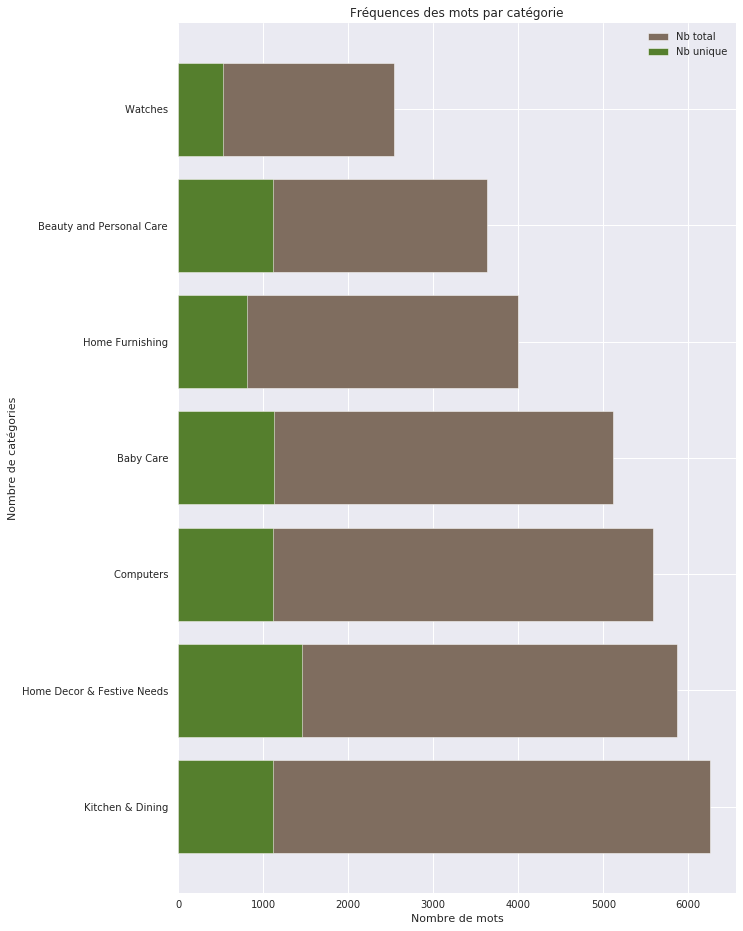

In [0]:
# Creation of token corpus by category
def creation_corpora(corpora, x):
    tokens = tokenizer.tokenize(x["description"].lower())
    corpora[x["product_category_tree"]] += [lemmatizer.lemmatize(w) for w
                                            in tokens if w not in list(sw) and
                                            len(w) > 3]


def freq_stats_corpora3(lookup_table=[]):
    corpora = defaultdict(list)
    description_data[["product_category_tree", 'description']].apply(
        lambda x: creation_corpora(corpora, x), axis=1)
    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}

    return (freq, stats, corpora)

lemmatizer = WordNetLemmatizer()

freq3, stats3, corpora3 = freq_stats_corpora3()
data_stats3 = pd.DataFrame.from_dict(stats3, orient='index')
data_stats3 = data_stats3.sort_values(by='total', ascending=False)
data_stats_plot3 = data_stats3.iloc[0:50]

print (data_stats_plot3.iloc[0])

# Frequencies display
labels3 = data_stats_plot3.index
sizes3 = data_stats_plot3['total']
sizes_unique3 = data_stats_plot3['unique']

sns.set()
barWidth = 0.5
fig, ax = plt.subplots(figsize=(10, 16))
ax.barh(labels3, sizes3, color='#7f6d5f', linewidth=barWidth,
        edgecolor='white', label='Nb total')
ax.barh(labels3, sizes_unique3, color='#557f2d', linewidth=barWidth,
        edgecolor='white', label='Nb unique')
plt.legend()
plt.ylabel('Nombre de catégories')
plt.xlabel('Nombre de mots')
plt.title("Fréquences des mots par catégorie")
plt.show()


# <h2>Classifications possibles à base du TF-IDF</h2>

Pour être certain des données conservées pour la classification, nous réeffectuons les étapes de nettoyage précédentes, avec quelques ajouts au traitement de base du texte. En effet, nous ne conservons que les noms et les verbes de plus de 3 lettres, et retirons la ponctuation, les nombres et les stopwords. 

In [0]:
def creation_corpora(corpora, x):
    tokens = tokenizer.tokenize(x["content"].lower())
    corpora[x["product_category_tree"]] += tokens


def token_corpora():
    corpora = defaultdict(list)
    description_data[["product_category_tree", 'content']].apply(
        lambda x: creation_corpora(corpora, x), axis=1)
    freq = dict()
    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
    return (corpora, freq)


def creation_sw(corpora, freq):
    # Retrieval of total frequencies of each word on all the corpus
    freq_totale = nltk.Counter()
    for k, v in corpora.items():
        freq_totale += freq[k]
    # Arbitrary decision of number of the most frequent words to delete
    most_freq = list(zip(*freq_totale.most_common(100)))[0]
    # Creation of the final stopword set, with the 100 most frequent
    # corpus words and all the default stopwords in NLTK library
    sw = set()
    sw.update(most_freq)
    sw.update(tuple(nltk.corpus.stopwords.words('english')))
    return (sw)

tokenizer = nltk.RegexpTokenizer(r'\w+')

corpora, freq = token_corpora()
print (corpora)
sw = creation_sw(corpora, freq)


defaultdict(<class 'list'>, {'Home Furnishing ': ['elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'key', 'features', 'of', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', '213', 'cm', 'in', 'height', 'pack', 'of', '2', 'price', 'rs', '899', 'this', 'curtain', 'enhances', 'the', 'look', 'of', 'the', 'interiors', 'this', 'curtain', 'is', 'made', 'from', '100', 'high', 'quality', 'polyester', 'fabric', 'it', 'features', 'an', 'eyelet', 'style', 'stitch', 'with', 'metal', 'ring', 'it', 'makes', 'the', 'room', 'environment', 'romantic', 'and', 'loving', 'this', 'curtain', 'is', 'ant', 'wrinkle', 'and', 'anti', 'shrinkage', 'and', 'have', 'elegant', 'apparance', 'give', 'your', 'home', 'a', 'bright', 'and', 'modernistic', 'appeal', 'with', 'these', 'designs', 'the', 'surreal', 'attention', 'is', 'sure', 'to', 'steal', 'hearts', '

In [0]:
def transformation(x):
    # print (x)
    liste1 = []
    liste2 = []
    liste = x.split()
    tagged = nltk.pos_tag(liste)
    # print ("Tag :",tagged)
    for i in tagged:
        if ('VB' in i[1] or 'NN' in i[1]):
            liste1.append(i[0])
    res = " ".join(liste1)
    for i in liste1:
        i = i.lower()
        # print ("minuscule :",i)
        i = i.translate(str.maketrans(" ", " ", string.punctuation))
        # print ("Sans ponctuation :",i)
        trans_table = str.maketrans({"0": " ", "1": " ", "2": " ", "3": " ",
                                     "4": " ", "5": " ", "6": " ", "7": " ",
                                     "8": " ", "9": " "})
        i = i.translate(trans_table)
        # print ("Sans chiffre :",i)
        i = i.replace(" ", "")
        # print ("Sans espace :",i)
        if len(i) < 3:
            # print ("Taille :",len(i))
            i = ''
            # print ("Sans mot < 3 lettres :",i)
        if i in list(sw):
            i = ''
            # print ("Sans stopword :",i)
        # print (liste)
        liste2.append(i)
    liste3 = [i.strip() for i in liste2 if (not i.isspace()) and (i != '')]
    # print (liste3," taille de ",len(liste3))
    if (len(liste3) == 0):
        return ''
    else:
        res = " ".join(liste3)
    # print ("Base :",liste)
    # print ("Sans verbe :",liste1)
    # print ("Final :",liste2)
    # print ("\n")
    # print ("Sortie")
    # print (res)
    # if (len(res))==0:
        # print (res)
    return (res)


def creation_corpora(corpora, x):
    tokens = tokenizer.tokenize(x["content"].lower())
    lems = [lemmatizer.lemmatize(transformation(w)) for w in tokens
            if (transformation(w) != '')]
    corpora[x["product_category_tree"]] += lems
    lemsjoin = " ".join(lems)
    return (lemsjoin)


def creation_prod(corpora, x):
    tokens = tokenizer.tokenize(x["products"].lower())
    lems = [lemmatizer.lemmatize(transformation(w)) for w in tokens
            if (transformation(w) != '')]
    lemsjoin = " ".join(lems)
    return (lemsjoin)


def token_corpora():
    corpora = defaultdict(list)
    description_data['content_norm'] = ''
    description_data['content_norm'] = description_data[[
        "product_category_tree", 'content', 'content_norm']].apply(
            lambda x: creation_corpora(corpora, x), axis=1)
    description_data['products_norm'] = ''
    description_data['products_norm'] = description_data[[
        "product_category_tree", 'products', 'products_norm']].apply(
            lambda x: creation_prod(corpora, x), axis=1)
    freq = dict()
    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
    return (corpora, freq)

tokenizer = nltk.RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

corpora, freq = token_corpora()
print (freq)
print (corpora)
print (description_data[['content', 'content_norm']])
print (description_data[['products', 'products_norm']])


{'Home Furnishing ': FreqDist({'cover': 125, 'towel': 93, 'cushion': 89, 'polyester': 82, 'curtain': 73, 'blanket': 70, 'quilt': 69, 'abstract': 68, 'eyelet': 63, 'door': 53, ...}), 'Baby Care ': FreqDist({'boy': 145, 'dress': 127, 'neck': 87, 'sleeve': 86, 'wash': 77, 'shirt': 77, 'pattern': 75, 'content': 74, 'blue': 64, 'fit': 59, ...}), 'Watches ': FreqDist({'discount': 134, 'boy': 102, 'dial': 91, 'strap': 81, 'sonata': 70, 'maximum': 69, 'digital': 63, 'girl': 56, 'resistant': 51, 'water': 51, ...}), 'Home Decor & Festive Needs ': FreqDist({'wall': 94, 'brass': 71, 'gift': 63, 'art': 55, 'light': 53, 'beautiful': 51, 'wooden': 47, 'paper': 47, 'room': 43, 'width': 43, ...}), 'Kitchen & Dining ': FreqDist({'mug': 130, 'gift': 114, 'rockmantra': 87, 'give': 75, 'loved': 72, 'prithish': 67, 'kadhai': 67, 'bottle': 66, 'pizza': 66, 'kitchen': 61, ...}), 'Beauty and Personal Care ': FreqDist({'hair': 57, 'soap': 50, 'oil': 49, 'jewellery': 47, 'trait': 42, 'cream': 41, 'kit': 38, 'bod

Nous utiliserons plusieurs associations d'algorithmes pour en étudier l'efficacité de la classification sur nos descriptions. Comme certaines fonctions sont utilisées à plusieures reprises, nous les implémentons dès maintenant. Il s'agit de :
- Les affichages de graphiques, que ce soit des catégories de base ou des clusters
- La réduction de dimensions par utilisation de TruncatedSVD
- Le kmeans, qu'ils soient de 1 à 7 classes (nombre défini dans notre data), ou directement à 7 classes.

In [0]:
# Fonctions used during TF-IDF


# Graph display
def plot_cat(data, X,titre):
    sns.set()
    fig, ax = plt.subplots(figsize=(10, 10))
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    legend = {}
    i = 0
    for c in data.unique():
        legend[c] = colors[i]
        i = i+1
    for i, name in zip(range(len(list(data))), list(data)):
        plt.scatter(X[i, 0], X[i, 1], c=legend[data.at[i]], label=name)
    # Delete legend duplicates
    handles, labels = ax.get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(handles, labels):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    plt.legend(handle_list, label_list)
    plt.title(titre)
    plt.show()

# Dimension reduction with TruncatedSVD
def dimension_reduction(values):
    for i in range(0, (values.shape[0]+1), 10):
        svd = TruncatedSVD(n_components=i)
        svd.fit(values)
        if (svd.explained_variance_ratio_.sum() >= 0.80):
            nb_dim = i
            break
    svd = TruncatedSVD(n_components=nb_dim)
    values_projected = svd.fit_transform(values)
    return (values_projected)


# K-means to verify cluster number
def kmeans(values):
    K = range(2, 10)
    distortions = []
    inertias = []
    silhouette = []
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=1)
        kmeanModel.fit(values)
        cluster_labels = kmeanModel.predict(values)
        inertias.append(kmeanModel.inertia_)
        silhouette_avg = metrics.silhouette_score(values, cluster_labels)
        silhouette.append(silhouette_avg)
        print("For n_clusters =", k, "The average silhouette_score is :",
              silhouette_avg)

    sns.set()
    plt.plot(K, silhouette, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Silhouette')
    plt.title('Values of average silhouette depending on K')
    plt.show()

    sns.set()
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method using Inertia')
    plt.show()


# K-means with 7 clusters
def kmeans7(values):
    kmeans = KMeans(n_clusters=7, random_state=1)
    kmeans.fit(values)
    y_kmeans = kmeans.predict(values)
    centers = kmeans.cluster_centers_
    columns = y

    print ("Nombre de clusters : ", len(centers))
    print ("Nombre de variables : ", len(y_kmeans))
    description_data['clusters_TFIDF_kmeans'] = y_kmeans

    sns.set()
    clusterstotal = description_data.groupby(['clusters_TFIDF_kmeans'])
    countclusterstotal = clusterstotal['clusters_TFIDF_kmeans'].count()
    countclusterstotal = countclusterstotal.sort_values(ascending=False)
    labels = countclusterstotal.index
    sizes = countclusterstotal.values
    return (y_kmeans)

tsne = TSNE(n_components=2, perplexity=50)


Dans cette partie, nous allons utiliser l'algorithme TF-IDF (Term-Frequency - Inverse Document Frequency) afin d'effectuer une pondération des mots selon leur fréquence d'utilisation. Ainsi, nous créons des bag of words représentant au mieux les différentes catégories, et pouvons nous en servir pour tenter de deviner les catégories des différents produits.

Ici, nous pouvons ainsi voir que cette technique seule, avec une réduction de dimensions, permet d'esquisser déjà des groupes visuellement distincts. 

Catégorie Home Furnishing   :  150
Catégorie Baby Care   :  150
Catégorie Watches   :  150
Catégorie Home Decor & Festive Needs   :  150
Catégorie Kitchen & Dining   :  150
Catégorie Beauty and Personal Care   :  150
Catégorie Computers   :  150


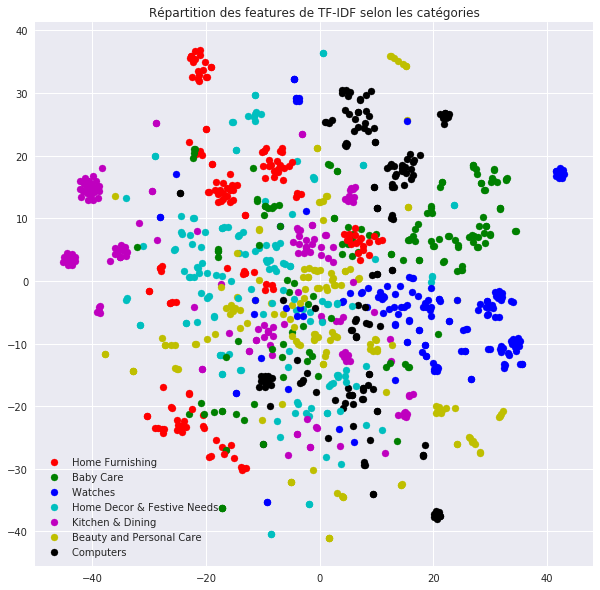

In [0]:
tfidf = TfidfVectorizer()
tfidf.fit(description_data['products_norm'])
values = tfidf.transform(description_data['content_norm'])

values_projected = dimension_reduction(values)

X_embedded = tsne.fit_transform(values_projected)
y = list(description_data['product_category_tree'])

for c in description_data['product_category_tree'].unique():
    print ("Catégorie", c, " : ", y.count(c))

plot_cat(description_data['product_category_tree'], X_embedded,
         "Répartition des features de TF-IDF selon les catégories")


On peut également utiliser la sortie du TF-IDF pour y appliquer un k-means qui va créer des clusters regroupant les différents produits. Nous devons faire 7 clusters afin de pouvoir comparer avec les données TF-IDF de base, mais nous pouvons voir, via le graphique, que cette séparation ne semble pas idéale avec nos données, et qu'un plus grand nombre de clusters serait conseillé. Cela est confirmé par la répartition des clusters, où l'un des clusters est prépondérant, et pourrait être divisé en plusieurs petits clusters si leur nombre avait été supérieur. Cela ne semble pas être la meilleure manière de traiter nos données.

For n_clusters = 2 The average silhouette_score is : 0.03673612064787553
For n_clusters = 3 The average silhouette_score is : 0.0449411633917893
For n_clusters = 4 The average silhouette_score is : 0.03835578732854682
For n_clusters = 5 The average silhouette_score is : 0.03217664156730077
For n_clusters = 6 The average silhouette_score is : 0.030915873972075427
For n_clusters = 7 The average silhouette_score is : 0.02505777286760632
For n_clusters = 8 The average silhouette_score is : 0.03302230043029678
For n_clusters = 9 The average silhouette_score is : 0.037497777789447795


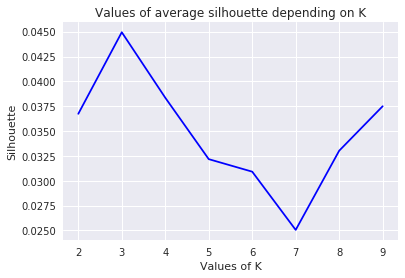

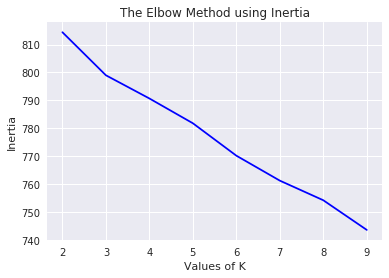

Nombre de clusters :  7
Nombre de variables :  1050
[6 5 5 ... 3 3 3]
Cluster 6  :  111
Cluster 5  :  30
Cluster 1  :  64
Cluster 3  :  719
Cluster 4  :  64
Cluster 2  :  32
Cluster 0  :  30


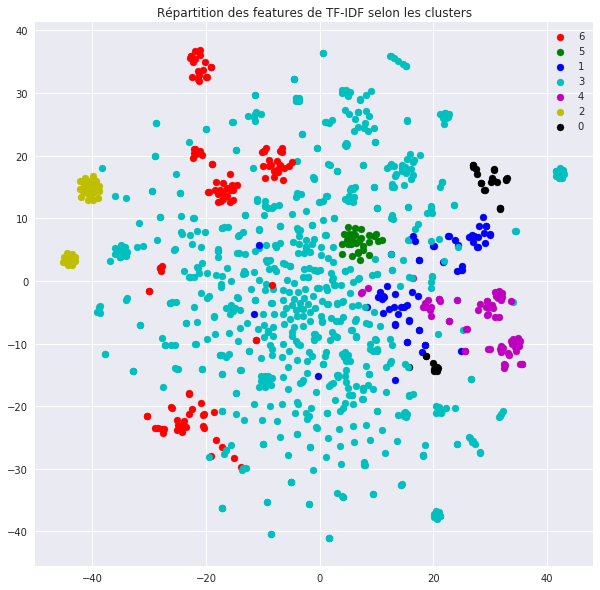

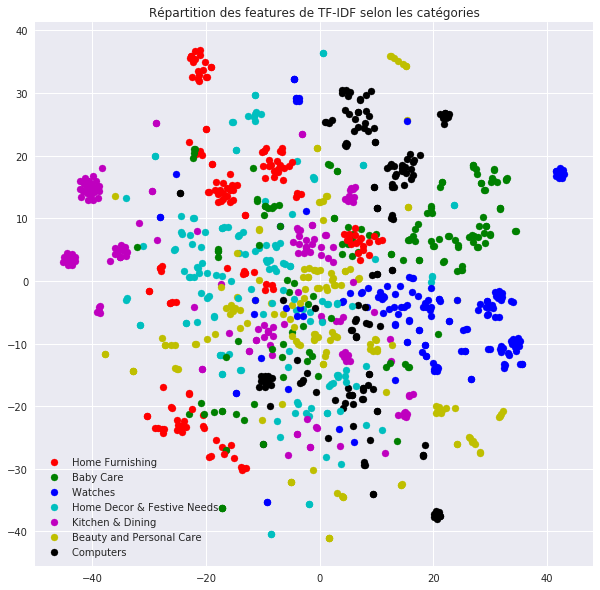

In [0]:
kmeans(values_projected)
y_kmeans = kmeans7(values_projected)
print (y_kmeans)

for c in description_data['clusters_TFIDF_kmeans'].unique():
    print ("Cluster", c, " : ", list(y_kmeans).count(c))

plot_cat(description_data['clusters_TFIDF_kmeans'], X_embedded,
         "Répartition des features de TF-IDF selon les clusters")
plot_cat(description_data['product_category_tree'], X_embedded,
         "Répartition des features de TF-IDF selon les catégories")


La deuxième méthode est d'utiliser la sortie du TF-IDF pour appliquer ensuite une NMF (Negative Matrix Factorisation) qui est une méthode automatique non supervisée de classification. On utilise ici un grand nombre de topics pour faire la séparation, afin d'obtenir une classification plus efficace. Cette méthode fonctionne visuellement un peu mieux que la méthode du TF-IDF seul, les groupes se dessinent un peu mieux. Lors de l'application des k-means, un groupe demeure toujours plus important que les autres.



Nombre de clusters :  7
Nombre de variables :  1050
[6 2 2 ... 6 6 6]
Cluster 6  :  972
Cluster 2  :  28
Cluster 0  :  3
Cluster 4  :  21
Cluster 1  :  10
Cluster 5  :  7
Cluster 3  :  9


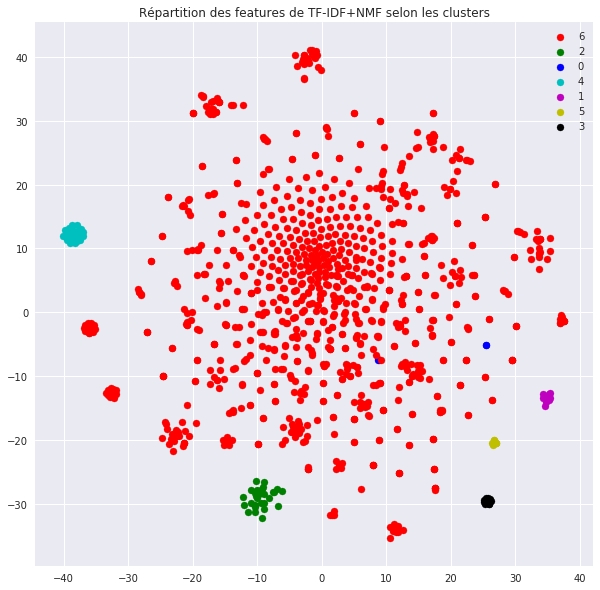

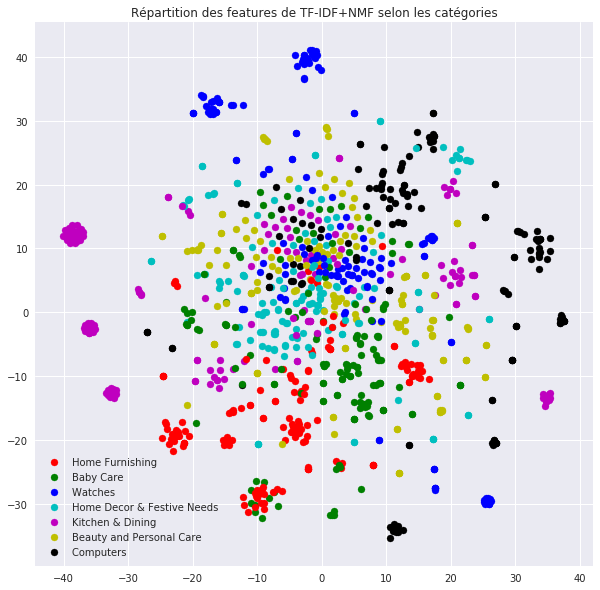

In [0]:
def kmeans7_NMF_numerous(values):
    kmeans = KMeans(n_clusters=7, random_state=1)
    kmeans.fit(values)
    y_kmeans = kmeans.predict(values)
    centers = kmeans.cluster_centers_
    columns = y

    print ("Nombre de clusters : ", len(centers))
    print ("Nombre de variables : ", len(y_kmeans))
    description_data['clusters_NMF_kmeans'] = y_kmeans

    sns.set()
    clusterstotal = description_data.groupby(['clusters_NMF_kmeans'])
    countclusterstotal = clusterstotal['clusters_NMF_kmeans'].count()
    countclusterstotal = countclusterstotal.sort_values(ascending=False)
    labels = countclusterstotal.index
    sizes = countclusterstotal.values
    return (y_kmeans)

# apply NMF
nmf = NMF(n_components=500, solver="mu")
W = nmf.fit_transform(values)
H = nmf.components_
idx_to_word = np.array(tfidf.get_feature_names())

X_embedded = tsne.fit_transform(W)

y_kmeans = kmeans7_NMF_numerous(W)
print (y_kmeans)

for c in description_data['clusters_NMF_kmeans'].unique():
    print ("Cluster", c, " : ", list(y_kmeans).count(c))

plot_cat(description_data['clusters_NMF_kmeans'], X_embedded,
         "Répartition des features de TF-IDF+NMF selon les clusters")
plot_cat(description_data['product_category_tree'], X_embedded,
         "Répartition des features de TF-IDF+NMF selon les catégories")


# <h2>Classifications possibles à base du count vectorizer</h2>

Pour être certain des données conservées pour la classification, nous réeffectuons les étapes de nettoyage précédentes, avec quelques ajouts au traitement de base du texte. En effet, nous ne conservons que les noms et les verbes de plus de 3 lettres, et retirons la ponctuation, les nombres et les stopwords. 

Nous réimplémentons également les fonctions d'affichage de graphiques, la réduction de dimensions par utilisation de TruncatedSVD et les kmeans

In [0]:
def creation_corpora(corpora, x):
    tokens = tokenizer.tokenize(x["content"].lower())
    corpora[x["product_category_tree"]] += tokens


def token_corpora():
    corpora = defaultdict(list)
    description_data[["product_category_tree", 'content']].apply(
        lambda x: creation_corpora(corpora, x), axis=1)
    freq = dict()
    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
    return (corpora, freq)


def creation_sw(corpora, freq):
    # Retrieval of total frequencies of each word on all the corpus
    freq_totale = nltk.Counter()
    for k, v in corpora.items():
        freq_totale += freq[k]
    # Arbitrary decision of number of the most frequent words to delete
    most_freq = list(zip(*freq_totale.most_common(100)))[0]
    # Creation of the final stopword set, with the 100 most frequent
    # corpus words and all the default stopwords in NLTK library
    sw = set()
    sw.update(most_freq)
    sw.update(tuple(nltk.corpus.stopwords.words('english')))
    return (sw)

tokenizer = nltk.RegexpTokenizer(r'\w+')

corpora, freq = token_corpora()
print (corpora)
sw = creation_sw(corpora, freq)


defaultdict(<class 'list'>, {'Home Furnishing ': ['elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'key', 'features', 'of', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', '213', 'cm', 'in', 'height', 'pack', 'of', '2', 'price', 'rs', '899', 'this', 'curtain', 'enhances', 'the', 'look', 'of', 'the', 'interiors', 'this', 'curtain', 'is', 'made', 'from', '100', 'high', 'quality', 'polyester', 'fabric', 'it', 'features', 'an', 'eyelet', 'style', 'stitch', 'with', 'metal', 'ring', 'it', 'makes', 'the', 'room', 'environment', 'romantic', 'and', 'loving', 'this', 'curtain', 'is', 'ant', 'wrinkle', 'and', 'anti', 'shrinkage', 'and', 'have', 'elegant', 'apparance', 'give', 'your', 'home', 'a', 'bright', 'and', 'modernistic', 'appeal', 'with', 'these', 'designs', 'the', 'surreal', 'attention', 'is', 'sure', 'to', 'steal', 'hearts', '

In [0]:
def transformation(x):
    # print (x)
    liste1 = []
    liste2 = []
    liste = x.split()
    tagged = nltk.pos_tag(liste)
    # print ("Tag :",tagged)
    for i in tagged:
        if ('VB' in i[1] or 'NN' in i[1]):
            liste1.append(i[0])
    res = " ".join(liste1)
    for i in liste1:
        i = i.lower()
        # print ("minuscule :",i)
        i = i.translate(str.maketrans(" ", " ", string.punctuation))
        # print ("Sans ponctuation :",i)
        trans_table = str.maketrans({"0": " ", "1": " ", "2": " ", "3": " ",
                                     "4": " ", "5": " ", "6": " ", "7": " ",
                                     "8": " ", "9": " "})
        i = i.translate(trans_table)
        # print ("Sans chiffre :",i)
        i = i.replace(" ", "")
        # print ("Sans espace :",i)
        if len(i) < 3:
            # print ("Taille :",len(i))
            i = ''
            # print ("Sans mot < 3 lettres :",i)
        if i in list(sw):
            i = ''
            # print ("Sans stopword :",i)
        # print (liste)
        liste2.append(i)
    liste3 = [i.strip() for i in liste2 if (not i.isspace()) and (i != '')]
    # print (liste3," taille de ",len(liste3))
    if (len(liste3) == 0):
        return ''
    else:
        res = " ".join(liste3)
    # print ("Base :",liste)
    # print ("Sans verbe :",liste1)
    # print ("Final :",liste2)
    # print ("\n")
    # print ("Sortie")
    # print (res)
    # if (len(res))==0:
        # print (res)
    return (res)


def creation_corpora(corpora, x):
    tokens = tokenizer.tokenize(x["content"].lower())
    lems = [lemmatizer.lemmatize(transformation(w)) for w in tokens
            if (transformation(w) != '')]
    corpora[x["product_category_tree"]] += lems
    lemsjoin = " ".join(lems)
    return (lemsjoin)


def creation_prod(corpora, x):
    tokens = tokenizer.tokenize(x["products"].lower())
    lems = [lemmatizer.lemmatize(transformation(w)) for w in tokens
            if (transformation(w) != '')]
    lemsjoin = " ".join(lems)
    return (lemsjoin)


def token_corpora():
    corpora = defaultdict(list)
    description_data['content_norm'] = ''
    description_data['content_norm'] = description_data[[
        "product_category_tree", 'content', 'content_norm']].apply(
            lambda x: creation_corpora(corpora, x), axis=1)
    description_data['products_norm'] = ''
    description_data['products_norm'] = description_data[[
        "product_category_tree", 'products', 'products_norm']].apply(
            lambda x: creation_prod(corpora, x), axis=1)
    freq = dict()
    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
    return (corpora, freq)

tokenizer = nltk.RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

corpora, freq = token_corpora()
print (freq)
print (corpora)
print (description_data[['content', 'content_norm']])
print (description_data[['products', 'products_norm']])


{'Home Furnishing ': FreqDist({'cover': 125, 'towel': 93, 'cushion': 89, 'polyester': 82, 'curtain': 73, 'blanket': 70, 'quilt': 69, 'abstract': 68, 'eyelet': 63, 'door': 53, ...}), 'Baby Care ': FreqDist({'boy': 145, 'dress': 127, 'neck': 87, 'sleeve': 86, 'wash': 77, 'shirt': 77, 'pattern': 75, 'content': 74, 'blue': 64, 'fit': 59, ...}), 'Watches ': FreqDist({'discount': 134, 'boy': 102, 'dial': 91, 'strap': 81, 'sonata': 70, 'maximum': 69, 'digital': 63, 'girl': 56, 'resistant': 51, 'water': 51, ...}), 'Home Decor & Festive Needs ': FreqDist({'wall': 94, 'brass': 71, 'gift': 63, 'art': 55, 'light': 53, 'beautiful': 51, 'wooden': 47, 'paper': 47, 'room': 43, 'width': 43, ...}), 'Kitchen & Dining ': FreqDist({'mug': 130, 'gift': 114, 'rockmantra': 87, 'give': 75, 'loved': 72, 'prithish': 67, 'kadhai': 67, 'bottle': 66, 'pizza': 66, 'kitchen': 61, ...}), 'Beauty and Personal Care ': FreqDist({'hair': 57, 'soap': 50, 'oil': 49, 'jewellery': 47, 'trait': 42, 'cream': 41, 'kit': 38, 'bod

In [0]:
# Fonctions used during CV


# Graph display
def plot_cat(data, X,titre):
    sns.set()
    fig, ax = plt.subplots(figsize=(10, 10))
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    legend = {}
    i = 0
    for c in data.unique():
        legend[c] = colors[i]
        i = i+1
    for i, name in zip(range(len(list(data))), list(data)):
        plt.scatter(X[i, 0], X[i, 1], c=legend[data.at[i]], label=name)
    # Delete legend duplicates
    handles, labels = ax.get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(handles, labels):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    plt.legend(handle_list, label_list)
    plt.title(titre)
    plt.show()

# Dimension reduction with TruncatedSVD
def dimension_reduction(values):
    for i in range(0, (values.shape[0]+1), 10):
        svd = TruncatedSVD(n_components=i)
        svd.fit(values)
        if (svd.explained_variance_ratio_.sum() >= 0.80):
            nb_dim = i
            break
    svd = TruncatedSVD(n_components=nb_dim)
    values_projected = svd.fit_transform(values)
    return (values_projected)


# K-means to verify cluster number
def kmeans(values):
    K = range(2, 10)
    distortions = []
    inertias = []
    silhouette = []
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=1)
        kmeanModel.fit(values)
        cluster_labels = kmeanModel.predict(values)
        inertias.append(kmeanModel.inertia_)
        silhouette_avg = metrics.silhouette_score(values, cluster_labels)
        silhouette.append(silhouette_avg)
        print("For n_clusters =", k, "The average silhouette_score is :",
              silhouette_avg)

    sns.set()
    plt.plot(K, silhouette, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Silhouette')
    plt.title('Values of average silhouette depending on K')
    plt.show()

    sns.set()
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method using Inertia')
    plt.show()


# K-means with 7 clusters
def kmeans7(values):
    kmeans = KMeans(n_clusters=7, random_state=1)
    kmeans.fit(values)
    y_kmeans = kmeans.predict(values)
    centers = kmeans.cluster_centers_
    columns = y

    print ("Nombre de clusters : ", len(centers))
    print ("Nombre de variables : ", len(y_kmeans))
    description_data['clusters_CV_kmeans'] = y_kmeans

    sns.set()
    clusterstotal = description_data.groupby(['clusters_CV_kmeans'])
    countclusterstotal = clusterstotal['clusters_CV_kmeans'].count()
    countclusterstotal = countclusterstotal.sort_values(ascending=False)
    labels = countclusterstotal.index
    sizes = countclusterstotal.values
    return (y_kmeans)

tsne = TSNE(n_components=2, perplexity=50)


Pour cette deuxième partie de classification par utilisation de texte, nous utilisons le CountVectorizer (ou CV). Cet algorithme va également effectuer une pondération des mots selon leur fréquence d'utilisation, mais en considérant chaque document séparement et sans pondérer plus fortement les mots apparaissant dans plusieurs documents. Nous obtenons ainsi un début de classification de manière visuelle, mais un peu moins visible que pour le TF-IDF seul.

Catégorie Home Furnishing   :  150
Catégorie Baby Care   :  150
Catégorie Watches   :  150
Catégorie Home Decor & Festive Needs   :  150
Catégorie Kitchen & Dining   :  150
Catégorie Beauty and Personal Care   :  150
Catégorie Computers   :  150


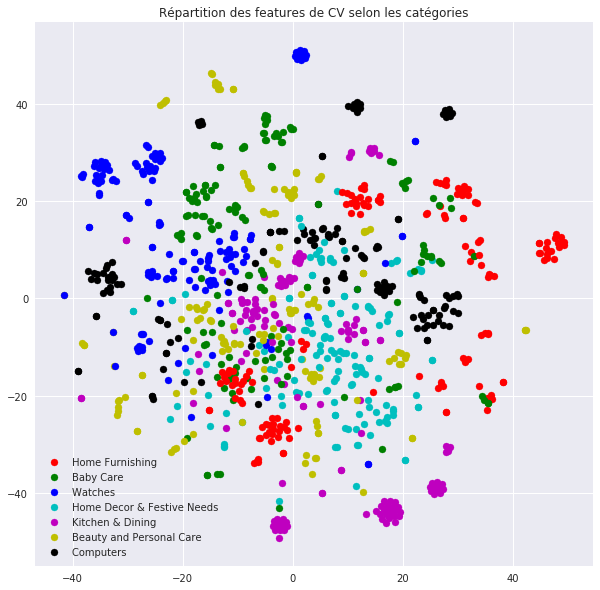

In [0]:
cv = CountVectorizer()
cv.fit(description_data['products_norm'])
valuescv = cv.transform(description_data['content_norm'])

values_projected = dimension_reduction(values)

X_embedded = tsne.fit_transform(values_projected)
y = list(description_data['product_category_tree'])

for c in description_data['product_category_tree'].unique():
    print ("Catégorie", c, " : ", y.count(c))

plot_cat(description_data['product_category_tree'], X_embedded,
         "Répartition des features de CV selon les catégories")


Lors de l'application du k-means à 7 clusters, comme précedémment, nous retrouvons le même problème. En effet, nous avons toujours un groupe prédominant par rapport aux autres, et la division en 7 clusters ne semble pas être optimal selon la silhouette moyenne.  

For n_clusters = 2 The average silhouette_score is : 0.03724954553217726
For n_clusters = 3 The average silhouette_score is : 0.01880467354918875
For n_clusters = 4 The average silhouette_score is : 0.03928417981484014
For n_clusters = 5 The average silhouette_score is : 0.02920100845425524
For n_clusters = 6 The average silhouette_score is : 0.016774252851668274
For n_clusters = 7 The average silhouette_score is : 0.023198839602957697
For n_clusters = 8 The average silhouette_score is : 0.034030187202290764
For n_clusters = 9 The average silhouette_score is : 0.039006354549747255


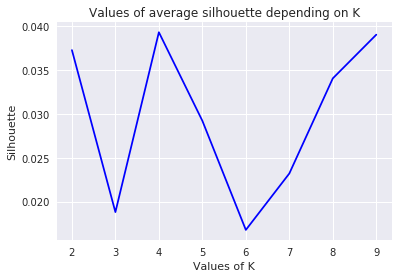

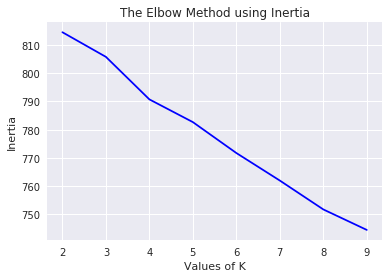

Nombre de clusters :  7
Nombre de variables :  1050
[6 5 5 ... 3 3 3]
Cluster 6  :  111
Cluster 5  :  30
Cluster 1  :  77
Cluster 3  :  714
Cluster 4  :  56
Cluster 2  :  32
Cluster 0  :  30


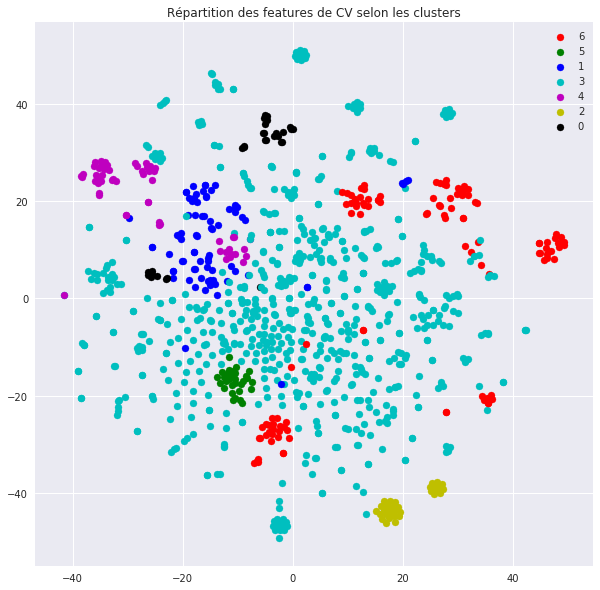

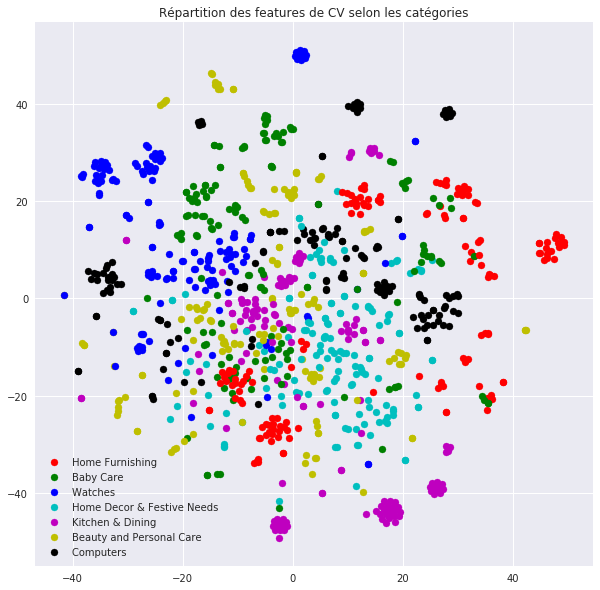

In [0]:
kmeans(values_projected)
y_kmeans = kmeans7(values_projected)
print (y_kmeans)

for c in description_data['clusters_CV_kmeans'].unique():
    print ("Cluster", c, " : ", list(y_kmeans).count(c))

plot_cat(description_data['clusters_CV_kmeans'], X_embedded,
         "Répartition des features de CV selon les clusters")
plot_cat(description_data['product_category_tree'], X_embedded,
         "Répartition des features de CV selon les catégories")


La seconde méthode est d'appliquer sur les features obtenus par CV une autre méthode de classification non supervisée, à savoir LDA (Latent Dirichlet Allocation), qui présume que chaque topic est un mélange d'un ensemble de mots, et que chaque document est un mélange de chaque topic. Comme fait précédemment avec le NMF, nous calculons tout d'abord 500 topics avec cette méthode, ce qui dessine également des groupes visibles, même si encore mélangés. Le kmeans à 7 clusters donne cependant toujours un groupe trop prépondérant par rapport aux autres.

Nombre de clusters :  7
Nombre de variables :  1050
[2 2 2 ... 2 2 2]
Cluster 2  :  969
Cluster 6  :  21
Cluster 0  :  13
Cluster 4  :  12
Cluster 3  :  20
Cluster 5  :  10
Cluster 1  :  5


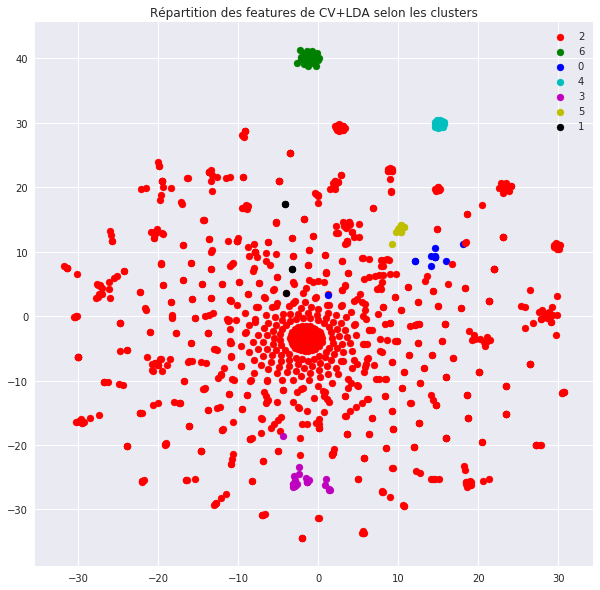

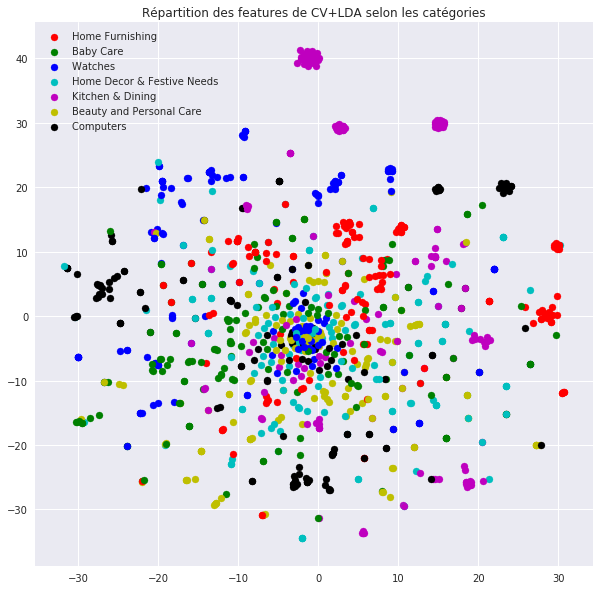

In [0]:
def kmeans7_LDA_numerous(values):
    kmeans = KMeans(n_clusters=7, random_state=1)
    kmeans.fit(values)
    y_kmeans = kmeans.predict(values)
    centers = kmeans.cluster_centers_
    columns = y

    print ("Nombre de clusters : ", len(centers))
    print ("Nombre de variables : ", len(y_kmeans))
    description_data['clusters_LDA_kmeans'] = y_kmeans

    sns.set()
    clusterstotal = description_data.groupby(['clusters_LDA_kmeans'])
    countclusterstotal = clusterstotal['clusters_LDA_kmeans'].count()
    countclusterstotal = countclusterstotal.sort_values(ascending=False)
    labels = countclusterstotal.index
    sizes = countclusterstotal.values
    return (y_kmeans)

# apply LDA
lda = LatentDirichletAllocation(n_components=500, random_state=1)

W_lda_numerous = lda.fit_transform(valuescv)
H = lda.components_
idx_to_word = np.array(cv.get_feature_names())

X_embedded = tsne.fit_transform(W_lda_numerous)

y_kmeans = kmeans7_LDA_numerous(W_lda_numerous)
print (y_kmeans)

for c in description_data['clusters_LDA_kmeans'].unique():
    print ("Cluster", c, " : ", list(y_kmeans).count(c))

plot_cat(description_data['clusters_LDA_kmeans'], X_embedded,
         "Répartition des features de CV+LDA selon les clusters")
plot_cat(description_data['product_category_tree'], X_embedded,
         "Répartition des features de CV+LDA selon les catégories")


# Classification par utilisation des images

<h2>Initialisation des données d'intérêt</h2>


Nous allons maintenant nous intéresser à une classification des produits en catégories, mais en utilisant pour cela les images fournies en plus des descriptions. En effet, de nombreux algorithmes existent afin d'extraire des features de ces images, et ainsi pouvoir les classifier. Pour commencer, nous observons les propriétés de nos différentes images : elles sont au nombre de 1050 et sont de poids différents, ce qui sous-entend que nous aurons certainement besoin de traiter ces images, que ce soit en tailles ou d'autres manières, détaillées par la suite. 

In [0]:
# specifying the zip file name
file_name = "Images.zip"

# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip1:
    # printing all the contents of the zip file
    zip1.printdir()

    # extracting all the files
    print('Extracting all the files now...')
    zip1.extractall()
    print('Done!')
del zip1

data_img = data[['image', 'product_category_tree']]

print (data_img['image'].unique())


File Name                                             Modified             Size
00e966a5049a262cfc72e6bbf68b80e7.jpg           2019-01-08 14:13:28       239215
00ed03657cedbe4663eff2d7fa702a33.jpg           2019-01-08 14:19:06       185970
0a3b5fdf77a361c2d7d9b29c259b8c4e.jpg           2019-01-08 14:15:58       283645
0a8a1e9c6659361c0c2b247f8a6471d0.jpg           2019-01-08 14:09:04      3337759
0abfcbe0e17dd50c4cf5fb1d6037d514.jpg           2019-01-08 14:08:48       159577
0ae859a69c7608d8197c3ba8c37bc6ec.jpg           2019-01-08 14:17:04       142374
0b8c4bc35aee94af356cb1fd2dfa0219.jpg           2019-01-08 14:13:50       310919
0b793c1727ef52285a25dedf8b86626b.jpg           2019-01-08 14:18:44       197244
0b852704f2002f8865a68818ad4951da.jpg           2019-01-08 14:14:08       217583
0bb0f7b7a3075f4b9459121abe2185fa.jpg           2019-01-08 14:09:36      1107432
0bff0eda7a6677dc1acb0477a1f7a121.jpg           2019-01-08 14:14:06       841673
0c70a580d96e50966130e2885d8c3505.jpg    

Done!
['55b85ea15a1536d46b7190ad6fff8ce7.jpg'
 '7b72c92c2f6c40268628ec5f14c6d590.jpg'
 '64d5d4a258243731dc7bbb1eef49ad74.jpg' ...
 '5912e037d12774bb73a2048f35a00009.jpg'
 'c3edc504d1b4f0ba6224fa53a43a7ad6.jpg'
 'f2f027ad6a6df617c9f125173da71e44.jpg']


Afin de tester les différentes méthodes de pré-processing des images, afin d'en tirer le meilleur, nous extrayons de nos données deux images assez différentes, pour trouver les traitements les plus adaptées. Le premier point remarquable est que les images font bel et bien des tailles différentes, et qu'il pourrait donc être nécessaire de les redimensionner pour certains algorithmes. Nous avons également pensé à prendre une image multicolore et une plutôt monochrome. 

Image 1 colorée
Largeur : 982 px, hauteur : 729 px
Format des pixels : RGB
Valeur du pixel situé en (20,100) : (255, 255, 255)

Image 2 peu colorée
Largeur : 515 px, hauteur : 800 px
Format des pixels : RGB
Valeur du pixel situé en (20, 100) : (255, 255, 255)



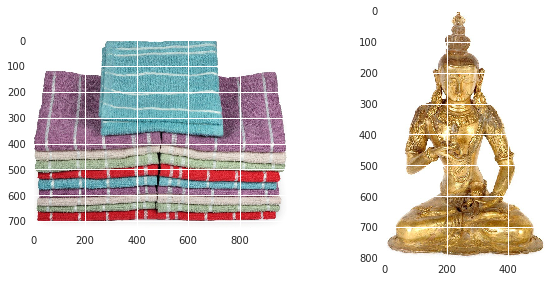

In [0]:
print ("Image 1 colorée")
n = 2
title = data_img['image'][n]
img = Image.open(title)
# Retrieve and display image sizes (in pixels)
w, h = img.size
print("Largeur : {} px, hauteur : {} px".format(w, h))
# Display its pixel format
print("Format des pixels : {}".format(img.mode))
# Retrieve and display pixel value at a precise position
px_value = img.getpixel((20, 100))
print("Valeur du pixel situé en (20,100) : {}\n".format(px_value))

print ("Image 2 peu colorée")
n = 90
title2 = data_img['image'][n]
img2 = Image.open(title2)
# Retrieve and display image sizes (in pixels)
w2, h2 = img2.size
print("Largeur : {} px, hauteur : {} px".format(w2, h2))
# Display its pixel format
print("Format des pixels : {}".format(img2.mode))
# Retrieve and display pixel value at a precise position
px_value2 = img2.getpixel((20, 100))
print("Valeur du pixel situé en (20, 100) : {}\n".format(px_value))


figure = plt.figure(figsize=(10, 10))
plt.subplot(221), plt.imshow(img)
plt.subplot(222), plt.imshow(img2)

plt.show()


Pour commencer, nous passons les images en greyscale, vu qu'elles seront testées ainsi dans les algorithmes. 

Nous testons ensuite comme premier traitement un changement d'exposition des images passées en grayscale. En effet, cette technique va étirer les histogrammes de niveau de gris afin de mieux répartir les pixels sur tout l'axe. Dans notre cas, vu la prédominance assez générale du fond blanc, cela ne donne pas grand chose, et cette technique ne sera donc pas appliquée sur nos images.

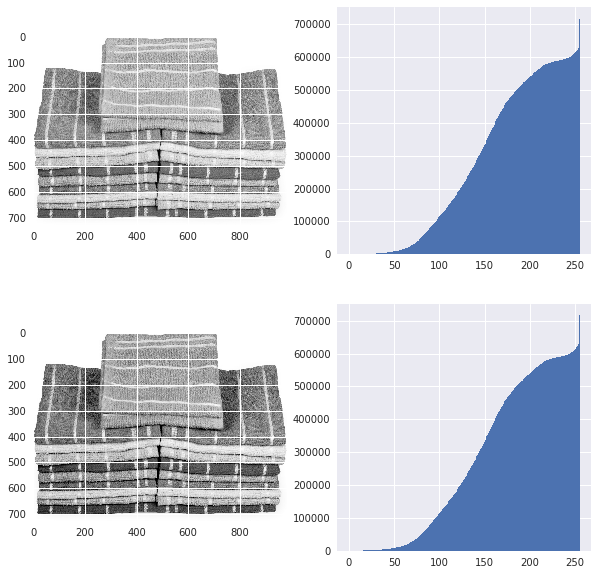

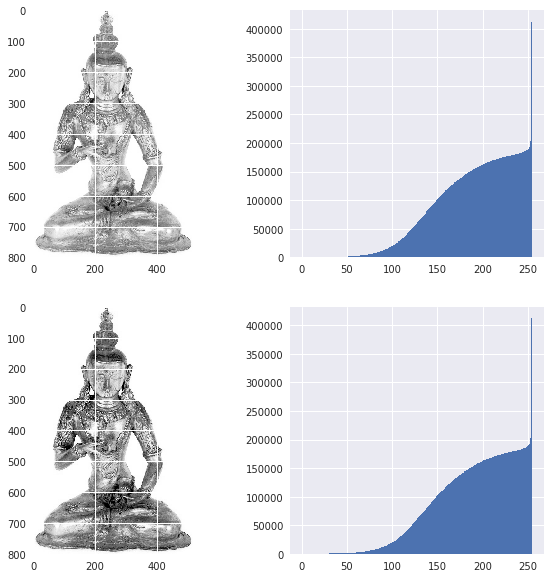

In [0]:
# Histogram stretching, exposition change
img = ImageOps.grayscale(Image.open(title))
img_arr = np.array(img)
img_surexp = ImageOps.autocontrast(img, cutoff=0.4, ignore=None)
img_surexp_arr = np.array(img_arr)

figure = plt.figure(figsize=(10, 10))
plt.subplot(221), plt.imshow(img, cmap='Greys_r')
plt.subplot(222), plt.hist(img_arr.flatten(), bins=range(256), cumulative=True)
plt.subplot(223), plt.imshow(img_surexp, cmap='Greys_r')
plt.subplot(224), plt.hist(img_surexp_arr.flatten(), bins=range(256),
                           cumulative=True)

plt.show()

img2 = ImageOps.grayscale(Image.open(title2))
img_arr2 = np.array(img2)
img_surexp2 = ImageOps.autocontrast(img2, cutoff=0.4, ignore=None)
img_surexp_arr2 = np.array(img_arr2)

figure = plt.figure(figsize=(10, 10))
plt.subplot(221), plt.imshow(img2, cmap='Greys_r')
plt.subplot(222), plt.hist(img_arr2.flatten(), bins=range(256),
                           cumulative=True)
plt.subplot(223), plt.imshow(img_surexp2, cmap='Greys_r')
plt.subplot(224), plt.hist(img_surexp_arr2.flatten(), bins=range(256),
                           cumulative=True)

plt.show()


Le deuxième traitement testé est un changement du contraste des images. Ceci va ainsi "égaliser les histogrammes", c'est à dire que tous les détails seront visibles sur l'image, et que la distribution des niveaux de gris va être harmonisée. Cela a un réel effet sur nos images, et nous conservons donc ce traitement pour la suite.

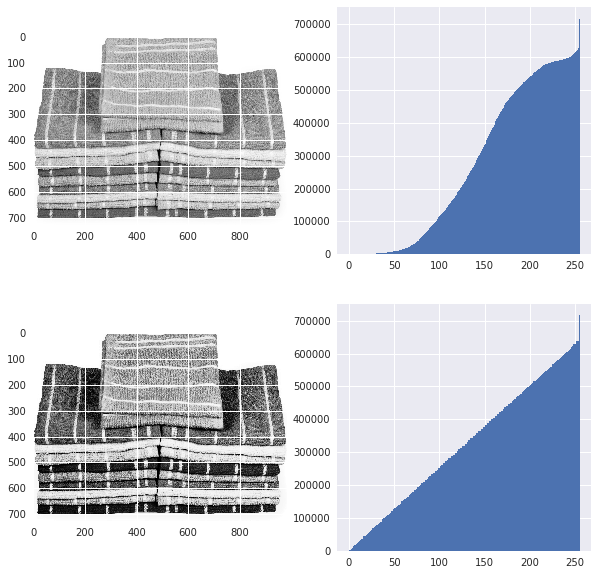

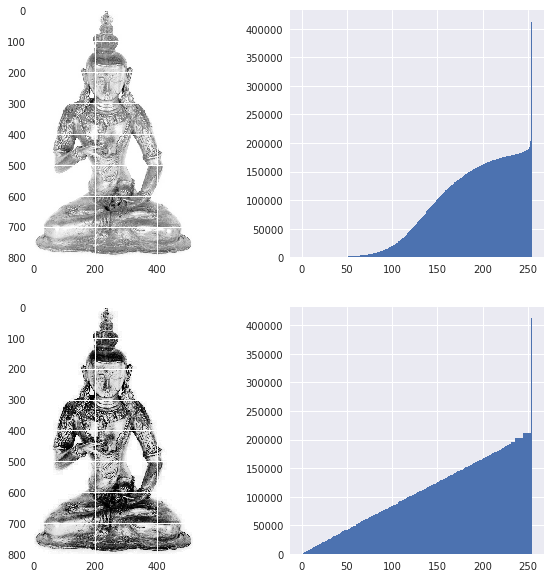

In [0]:
#  Histogram equalization, contrast change

img = ImageOps.grayscale(Image.open(title))
img_arr = np.array(img)
img_equal = ImageOps.equalize(img)
img_equal_arr = np.array(img_equal)


figure = plt.figure(figsize=(10, 10))
plt.subplot(221), plt.imshow(img, cmap='Greys_r')
plt.subplot(222), plt.hist(img_arr.flatten(), bins=range(256), cumulative=True)
plt.subplot(223), plt.imshow(img_equal, cmap='Greys_r')
plt.subplot(224), plt.hist(img_equal_arr.flatten(), bins=range(256),
                           cumulative=True)

plt.show()

img2 = ImageOps.grayscale(Image.open(title2))
img_arr2 = np.array(img2)
img_equal2 = ImageOps.equalize(img2)
img_equal_arr2 = np.array(img_equal2)


figure = plt.figure(figsize=(10, 10))
plt.subplot(221), plt.imshow(img2, cmap='Greys_r')
plt.subplot(222), plt.hist(img_arr2.flatten(), bins=range(256),
                           cumulative=True)
plt.subplot(223), plt.imshow(img_equal2, cmap='Greys_r')
plt.subplot(224), plt.hist(img_equal_arr2.flatten(), bins=range(256),
                           cumulative=True)

plt.show()


Ce troisième traitement testé est un lissage par moyennage, ce qui aura pour effet de retirer, ou du moins réduire, le bruit des images en remplaçant la valeur de chaque pixel par l'intensité moyenne de son voisinage. Dans notre cas, il ne semblait cependant ne pas y avoir de bruit, ce qui est confirmé par nos résultats, et ce traitement ne sera donc pas utilisé. 

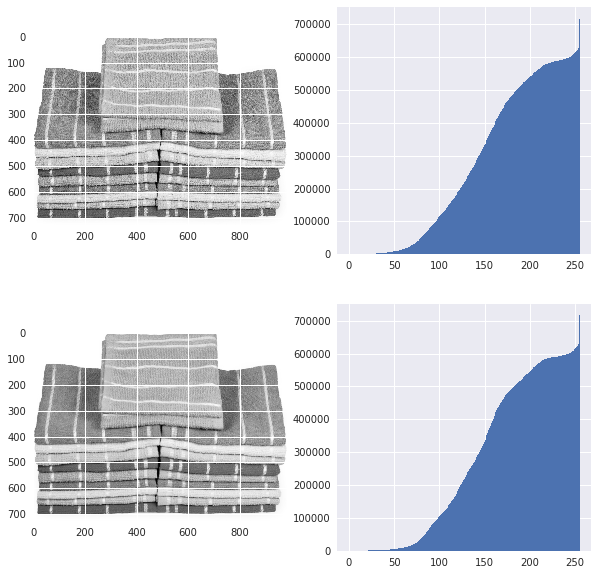

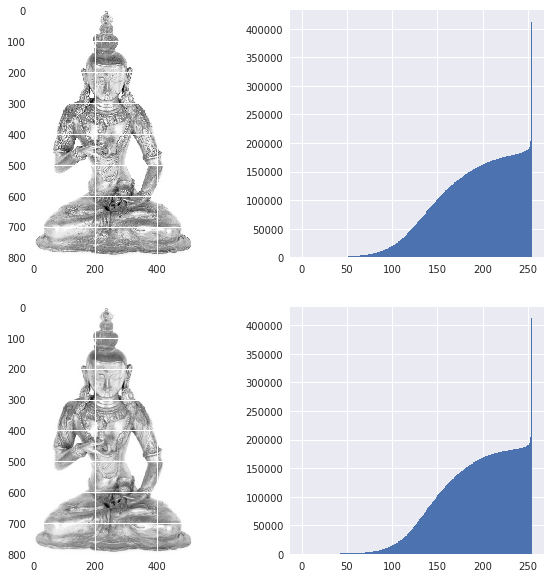

In [0]:
# Smoothing by averaging
img = ImageOps.grayscale(Image.open(title))
img_arr = np.array(img)
img_blur = img.filter(ImageFilter.BoxBlur(1))
img_blur_arr = np.array(img_blur)

figure = plt.figure(figsize=(10, 10))
plt.subplot(221), plt.imshow(img, cmap='Greys_r')
plt.subplot(222), plt.hist(img_arr.flatten(), bins=range(256), cumulative=True)
plt.subplot(223), plt.imshow(img_blur, cmap='Greys_r')
plt.subplot(224), plt.hist(img_blur_arr.flatten(), bins=range(256),
                           cumulative=True)
plt.show()

img2 = ImageOps.grayscale(Image.open(title2))
img_arr2 = np.array(img2)
img_blur2 = img2.filter(ImageFilter.BoxBlur(1))
img_blur_arr2 = np.array(img_blur2)

figure = plt.figure(figsize=(10, 10))
plt.subplot(221), plt.imshow(img2, cmap='Greys_r')
plt.subplot(222), plt.hist(img_arr2.flatten(), bins=range(256),
                           cumulative=True)
plt.subplot(223), plt.imshow(img_blur2, cmap='Greys_r')
plt.subplot(224), plt.hist(img_blur_arr2.flatten(), bins=range(256),
                           cumulative=True)
plt.show()


Enfin, pour le dernier traitement, nous testons un autre exemple de filtre pour atténuer le bruit, à savoir le filtre gaussien. Comme montré précédemment et supposé sur la base d'un premier visionnage des photos, ce traitement n'a pas d'effet sur nos images et ne sera donc pas utilisé. 

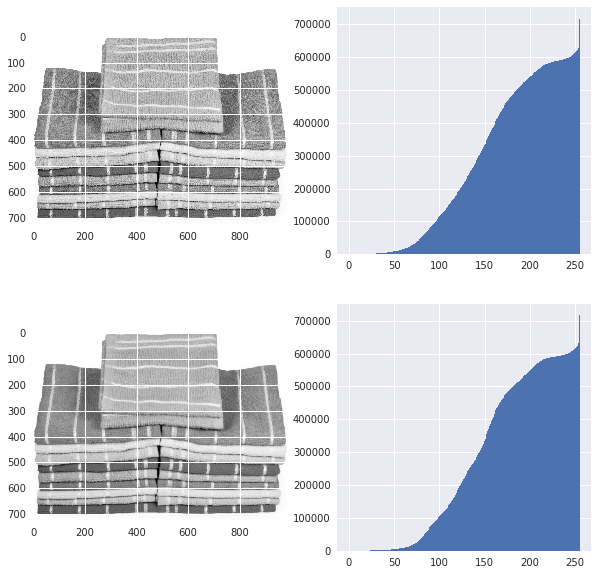

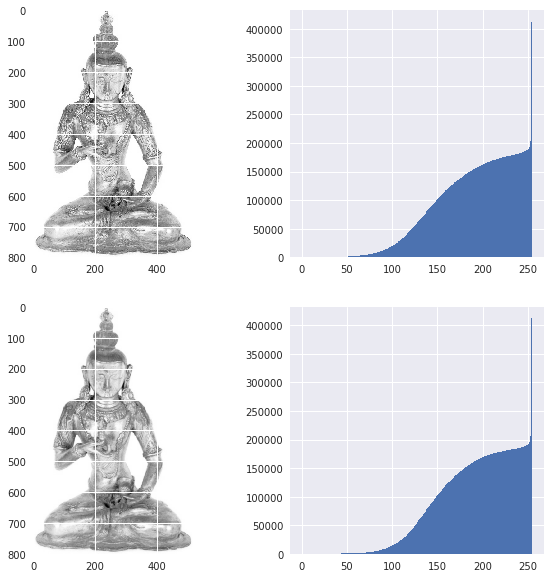

In [0]:
# Gaussian filter
img = ImageOps.grayscale(Image.open(title))
img_arr = np.array(img)
img_blur = img.filter(ImageFilter.GaussianBlur(1))
img_blur_arr = np.array(img_blur)

figure = plt.figure(figsize=(10, 10))
plt.subplot(221), plt.imshow(img, cmap='Greys_r')
plt.subplot(222), plt.hist(img_arr.flatten(), bins=range(256),
                           cumulative=True)
plt.subplot(223), plt.imshow(img_blur, cmap='Greys_r')
plt.subplot(224), plt.hist(img_blur_arr.flatten(), bins=range(256),
                           cumulative=True)

plt.show()

img2 = ImageOps.grayscale(Image.open(title2))
img_arr2 = np.array(img2)
img_blur2 = img2.filter(ImageFilter.GaussianBlur(1))
img_blur_arr2 = np.array(img_blur2)

figure = plt.figure(figsize=(10, 10))
plt.subplot(221), plt.imshow(img2, cmap='Greys_r')
plt.subplot(222), plt.hist(img_arr2.flatten(), bins=range(256),
                           cumulative=True)
plt.subplot(223), plt.imshow(img_blur2, cmap='Greys_r')
plt.subplot(224), plt.hist(img_blur_arr2.flatten(), bins=range(256),
                           cumulative=True)

plt.show()


# <h2>Classifications possibles à base de SIFT

La première méthode de classification de nos images est d'utiliser la méthode SIFT (Scale-invariant feature transform). Cette méthode extrait des features (ou points d'intérêt) de l'image et calcule leurs descripteurs, afin de repérer ensuite (par la méthode BOWKmeansTrainer) les paires de features qui se ressemblent le plus dans 2 images. Ici, nous utilisons 100 clusters en sortie de notre méthode, afin de respecter à la fois un temps de calcul raisonnable et un bon ensemble de features pour classifier nos images ensuite.

In [0]:
img_title_table = []

sift = cv2.xfeatures2d.SIFT_create()
detect = cv2.xfeatures2d.SIFT_create()
print ("Début BOW")
print ("Début calcul")
descriptors_list = []
for n in range(len(data_img['image'])):
    if (n % 50 == 0):
        print (n, "images traitées sur ", len(data_img['image']))
    title = data_img['image'][n]
    img_title_table.append(title)
    img = ImageOps.grayscale(Image.open(title))
    img = ImageOps.equalize(img)
    img_arr = np.array(img)
    keypoints, descriptors = sift.detectAndCompute(img_arr, None)
    descriptors_list.append(descriptors)
descriptors_nb = 0
for n in descriptors_list:
    descriptors_nb += len(n)
print (descriptors_nb)


start_time = time.time()
# BOW = cv2.BOWKMeansTrainer(int(np.sqrt(descriptors_nb)))
BOW = cv2.BOWKMeansTrainer(100)
for n in range(len(descriptors_list)):
    BOW.add(descriptors)
print ("Fin calcul")

voc = BOW.cluster()
print("Temps d execution : %s secondes ---" % (time.time() - start_time))
print (voc)
print (voc.shape)


Début BOW
Début calcul
0 images traitées sur  1050
50 images traitées sur  1050
100 images traitées sur  1050
150 images traitées sur  1050
200 images traitées sur  1050
250 images traitées sur  1050
300 images traitées sur  1050
350 images traitées sur  1050
400 images traitées sur  1050
450 images traitées sur  1050
500 images traitées sur  1050
550 images traitées sur  1050
600 images traitées sur  1050
650 images traitées sur  1050
700 images traitées sur  1050
750 images traitées sur  1050
800 images traitées sur  1050
850 images traitées sur  1050
900 images traitées sur  1050
950 images traitées sur  1050
1000 images traitées sur  1050
10394751
Fin calcul
Temps d execution : 15278.085840702057 secondes ---
[[ 8.75       9.921053  23.723684  ... 21.644737  11.921053  16.736841 ]
 [36.725273  66.30769   36.043957  ... 25.89011   12.285714  12.769231 ]
 [22.736841  28.776316  25.342104  ... 20.118422  18.5       16.973684 ]
 ...
 [33.125     20.727272  12.477272  ... 29.69318   12.

Une fois ce dictionnaire des features visuelles créé, nous l'utilisons pour créer les histogrammes indiquant la fréquence d'apparition de chaque cluster dans l'image. 

In [0]:
def get_visual_word_histogram_of_images(vocabulary):
    sift = cv2.xfeatures2d.SIFT_create()
    bow_ext = cv2.BOWImgDescriptorExtractor(sift, cv2.BFMatcher(cv2.NORM_L2))
    bow_ext.setVocabulary(vocabulary)

    bow_list = []
    for n in range(len(data_img['image'])):
        if (n % 50 == 0):
            print (n, "images traitées sur ", len(data_img['image']))
        title = data_img['image'][n]
        img_title_table.append(title)
        img = ImageOps.grayscale(Image.open(title))
        img = ImageOps.equalize(img)
        img_arr = np.array(img)
        keypoints, descriptors = sift.detectAndCompute(img_arr, None)
        histogram = bow_ext.compute(img_arr, keypoints)[0]
        bow_list.append(histogram)
    return (bow_list)

print ("Fin BOW")
print ("Début Descriptor Extractor")

bow_list = get_visual_word_histogram_of_images(voc)
print (bow_list)


Fin BOW
Début Descriptor Extractor
0 images traitées sur  1050
50 images traitées sur  1050
100 images traitées sur  1050
150 images traitées sur  1050
200 images traitées sur  1050
250 images traitées sur  1050
300 images traitées sur  1050
350 images traitées sur  1050
400 images traitées sur  1050
450 images traitées sur  1050
500 images traitées sur  1050
550 images traitées sur  1050
600 images traitées sur  1050
650 images traitées sur  1050
700 images traitées sur  1050
750 images traitées sur  1050
800 images traitées sur  1050
850 images traitées sur  1050
900 images traitées sur  1050
950 images traitées sur  1050
1000 images traitées sur  1050
[array([0.01292911, 0.00155393, 0.00288442, 0.0167987 , 0.00710949,
       0.0037985 , 0.00229535, 0.00789153, 0.00400162, 0.00250863,
       0.01024782, 0.00196019, 0.001818  , 0.0041235 , 0.05299614,
       0.00161487, 0.0038899 , 0.00816575, 0.00223441, 0.01574243,
       0.03641072, 0.01724558, 0.00530165, 0.01155799, 0.00817591,
 

Nous utilisons ensuite ces histogrammes pour chaque image afin d'effectuer la classification. Pour cela, nous réduisons tout d'abord la dimensions de cette variable, puis nous y appliquons une T-SNE. Cependant, par cette méthode, nous n'obtenons pas de résultat, vu qu'aucun groupe ne se dessine sur le graphique. En appliquant dessus un k-means à 7 clusters, nous voyons cependant une meilleure répartition dans les clusters, même si un groupe reste supérieur en nombre d'images (400 images, contre les 900 des k-means de la classification par texte). Cette méthode ne semble cependant pas être la meilleure pour classifier nos images.

Catégorie Home Furnishing   :  150
Catégorie Baby Care   :  150
Catégorie Watches   :  150
Catégorie Home Decor & Festive Needs   :  150
Catégorie Kitchen & Dining   :  150
Catégorie Beauty and Personal Care   :  150
Catégorie Computers   :  150


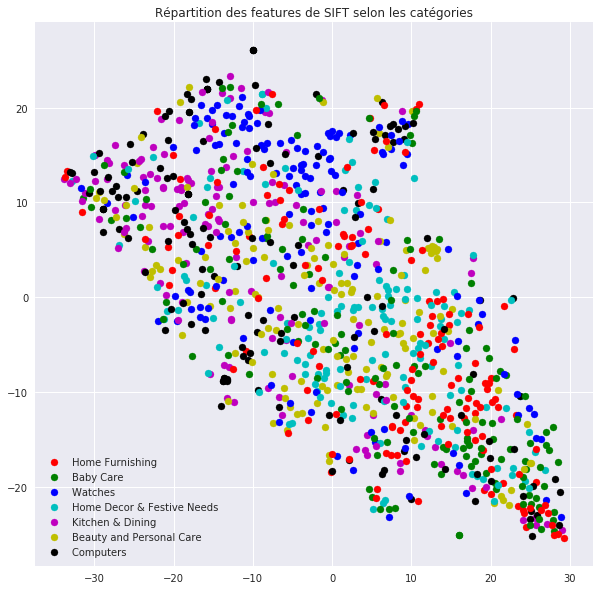

In [0]:
def dimension_reduction(values):
    for i in range(0, (len(values)+1)):
        svd = TruncatedSVD(n_components=i)
        svd.fit(values)
        if (svd.explained_variance_ratio_.sum() >= 0.80):
            nb_dim = i
            break
    svd = TruncatedSVD(n_components=nb_dim)
    values_projected = svd.fit_transform(values)
    return (values_projected)


def plot_cat(data, X, titre):
    sns.set()
    fig, ax = plt.subplots(figsize=(10, 10))
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    legend = {}
    i = 0
    for c in data.unique():
        legend[c] = colors[i]
        i = i+1
    for i, name in zip(range(len(list(data))), list(data)):
        plt.scatter(X[i, 0], X[i, 1], c=legend[data.at[i]], label=name)
    # Delete legend duplicates
    handles, labels = ax.get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(handles, labels):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    plt.legend(handle_list, label_list)
    plt.title(titre)
    plt.show()

values_projected = dimension_reduction(bow_list)
tsne = TSNE(n_components=2, perplexity=50)
X_embedded = tsne.fit_transform(values_projected)
y = list(data_img['product_category_tree'])

for c in data_img['product_category_tree'].unique():
    print ("Catégorie", c, " : ", y.count(c))

plot_cat(data_img['product_category_tree'], X_embedded,
         "Répartition des features de SIFT selon les catégories")


For n_clusters = 2 The average silhouette_score is : 0.31688306
For n_clusters = 3 The average silhouette_score is : 0.21964481
For n_clusters = 4 The average silhouette_score is : 0.19392839
For n_clusters = 5 The average silhouette_score is : 0.21457854
For n_clusters = 6 The average silhouette_score is : 0.20738202
For n_clusters = 7 The average silhouette_score is : 0.21538068
For n_clusters = 8 The average silhouette_score is : 0.19951172
For n_clusters = 9 The average silhouette_score is : 0.1681103


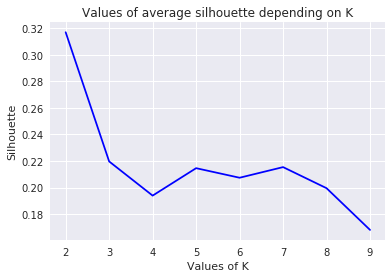

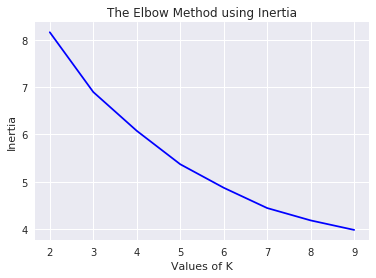

Nombre de clusters :  7
Nombre de variables :  1050
[4 1 1 ... 0 5 1]
Cluster 4  :  181
Cluster 1  :  427
Cluster 5  :  167
Cluster 0  :  157
Cluster 6  :  38
Cluster 3  :  72
Cluster 2  :  8


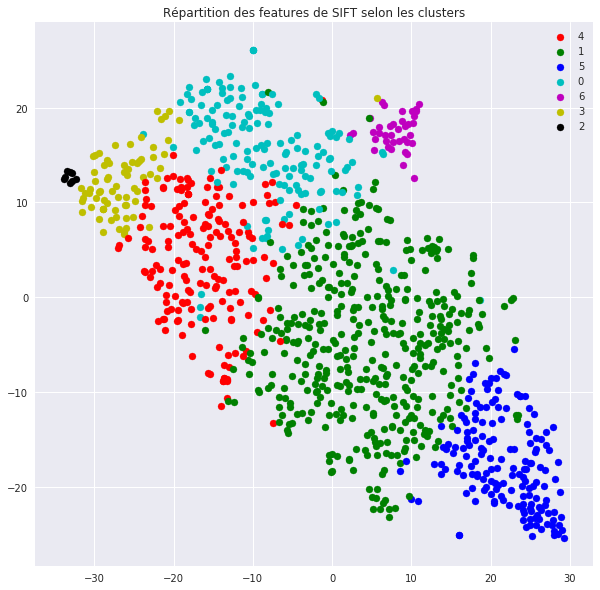

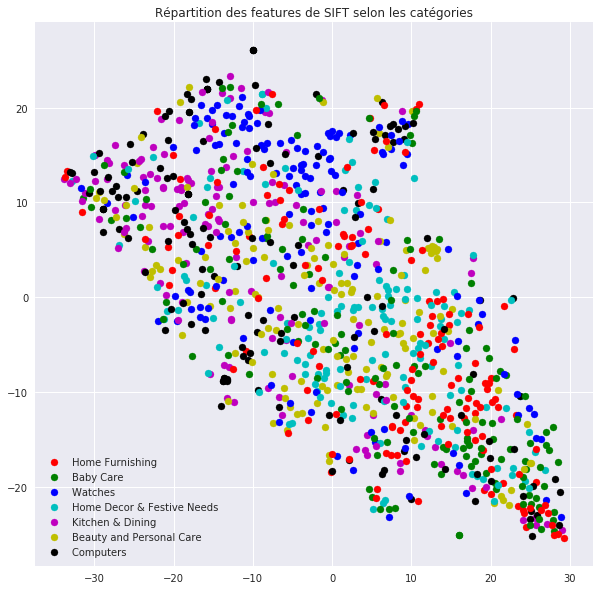

In [0]:
# K-means to verify cluster number
def kmeans(values):
    K = range(2, 10)
    distortions = []
    inertias = []
    silhouette = []
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=1)
        kmeanModel.fit(values)
        cluster_labels = kmeanModel.predict(values)
        inertias.append(kmeanModel.inertia_)
        silhouette_avg = metrics.silhouette_score(values, cluster_labels)
        silhouette.append(silhouette_avg)
        print("For n_clusters =", k, "The average silhouette_score is :",
              silhouette_avg)

    sns.set()
    plt.plot(K, silhouette, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Silhouette')
    plt.title('Values of average silhouette depending on K')
    plt.show()

    sns.set()
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method using Inertia')
    plt.show()


# K-means with 7 clusters
def kmeans7(values):
    kmeans = KMeans(n_clusters=7, random_state=1)
    kmeans.fit(values)
    y_kmeans = kmeans.predict(values)
    centers = kmeans.cluster_centers_
    columns = y

    print ("Nombre de clusters : ", len(centers))
    print ("Nombre de variables : ", len(y_kmeans))
    data_img['clusters_SIFT_kmeans'] = y_kmeans

    sns.set()
    clusterstotal = data_img.groupby(['clusters_SIFT_kmeans'])
    countclusterstotal = clusterstotal['clusters_SIFT_kmeans'].count()
    countclusterstotal = countclusterstotal.sort_values(ascending=False)
    labels = countclusterstotal.index
    sizes = countclusterstotal.values
    return (y_kmeans)

kmeans(values_projected)
y_kmeans = kmeans7(values_projected)
print (y_kmeans)

for c in data_img['clusters_SIFT_kmeans'].unique():
    print ("Cluster", c, " : ", list(y_kmeans).count(c))

plot_cat(data_img['clusters_SIFT_kmeans'], X_embedded,
         "Répartition des features de SIFT selon les clusters")
plot_cat(data_img['product_category_tree'], X_embedded,
         "Répartition des features de SIFT selon les catégories")


# <h2>Classifications possibles à base de Keras

La deuxième méthode utilisée pour classifier les produits selon les images est l'utilisation d'un modèle pré-établi dans Keras. L'utilisation de ce modèle va limiter les temps de traitement (qui sont extrèmement longs avec l'algorithme SIFT), mais aussi nous permettre d'obtenir de meilleurs résultats de par le pré-entraînement : en effet, si le modèle sait déjà reconnaître des objets, l'utiliser sur de nouvelles images donnera de meilleurs résultats que sur un modèle naïf.

Nous commençons donc par charger toutes nos images dont la taille est harmonisée, et à les intégrer dans une variable de type ImageDataGenerator.

In [0]:
liste = []
for n in range(len(data['image'])):
    img = Image.open(data['image'][n])
    img = img.resize([224, 224])
    img = np.array(img)
    liste.append(img)
liste = np.array(liste)

with open("liste_images", "wb") as fp:   # Pickling
    pickle.dump(liste, fp)


In [0]:
with open("liste_images", "rb") as fp:   # Unpickling
    data_img = pickle.load(fp)

X = data_img.astype('float32')
X = X*1.0/255.0

width = X.shape[1]
channels = X.shape[3]
print("Nombre d'images : ", len(X))
print("Image dimension       : ", width, "x", width, "x", channels)

img_width, img_height = width, width
batch_size = 1
nb_samples = len(X)

datagen_mat = keras.preprocessing.image.ImageDataGenerator()
generator_mat = datagen_mat.flow(X, batch_size=batch_size, shuffle=False)
print(generator_mat[0].shape)


Nombre d'images :  1050
Image dimension       :  224 x 224 x 3
(1, 224, 224, 3)


Pour notre classification, nous utilisons le modèle "InceptionResnetV2" quiest un réseau neuronal entraîné sur plus d'un million d'image de la base de données ImageNet, et qui peut classifier ces images en 1000 catégories d'objets, ce qui correspond plutôt bien à notre classification recherchée (par le fait que ce sont aussi des objets).

In [0]:
model_InceptionResNetV2 = keras.applications.InceptionResNetV2(
    include_top=False, weights='imagenet')
features_InceptionResNetV2 = model_InceptionResNetV2.predict_generator(
    generator_mat, steps=len(generator_mat), verbose=0)


Les features obtenus grâce à notre modèle sont ensuite traités comme les features précédentes, à savoir une réduction de dimensions et un Kmeans à 7 clusters. Les graphiques en résultant nous montrent de très bons résultats, à savoir une bonne visibilité de groupes d'objets plutôt bien répartis et séparés. Les clusters du K-means sont également bien répartis, avec un groupe prépondérant moins important que dans nos autres méthodes.

(1050, 5, 5, 1536)
(1050, 38400)


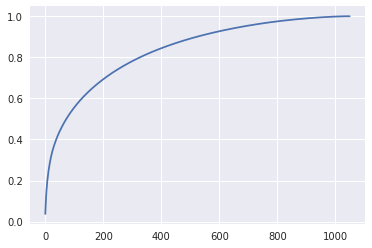

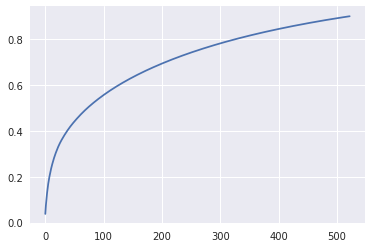

Catégorie 0  :  305
Catégorie 1  :  315
Catégorie 2  :  80
Catégorie 3  :  139
Catégorie 4  :  88
Catégorie 5  :  116
Catégorie 6  :  7


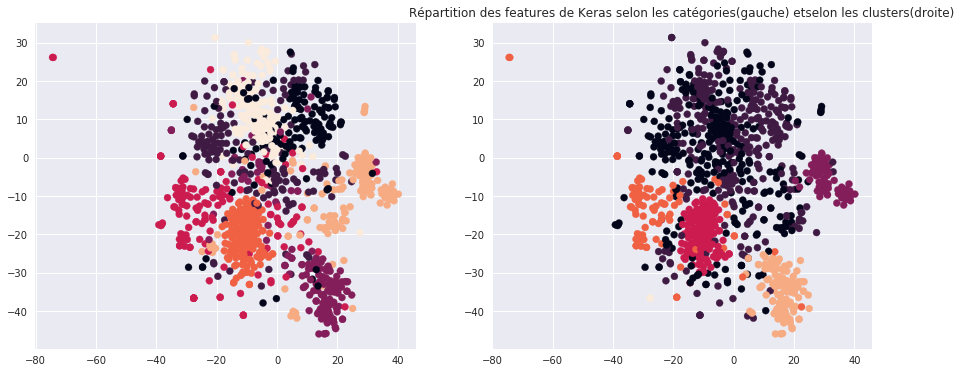

In [0]:
def dimension_reduction(values):
    std_scale = preprocessing.StandardScaler().fit(values)
    data_s = std_scale.transform(values)
    pca = decomposition.PCA(n_components=None, svd_solver='auto')
    pca.fit(data_s)
    data_pca = pca.transform(data_s)
    pca_ratio = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(pca_ratio)
    plt.show()
    std_scale2 = preprocessing.StandardScaler().fit(values)
    data_s2 = std_scale2.transform(values)
    pca2 = decomposition.PCA(n_components=0.9, svd_solver='auto')
    pca2.fit(data_s2)
    data_pca2 = pca2.transform(data_s2)
    pca_ratio2 = np.cumsum(pca2.explained_variance_ratio_)
    plt.plot(pca_ratio2)
    plt.show()
    return (data_pca2)

print(features_InceptionResNetV2.shape)
shape = features_InceptionResNetV2.shape
features_IRN = features_InceptionResNetV2.reshape(shape[0],
                                                  shape[1]*shape[2]*shape[3])
print (features_IRN.shape)

values_projected = dimension_reduction(features_IRN)

kmeans = KMeans(n_clusters=7, n_init=100)
kmeans.fit(values_projected)
y_kmeans = kmeans.predict(values_projected)

tsne = TSNE(n_components=2, perplexity=50, n_iter=3000, init='pca',
            learning_rate=1000.0)

X_embedded = tsne.fit_transform(values_projected)

l_cat = list(set(data['product_category_tree']))
cat_num = [l_cat.index(data.iloc[i][
    'product_category_tree']) for i in range(len(data))]
yr = cat_num

list_cat = data['product_category_tree']

for c in np.unique(y_kmeans):
    print ("Catégorie", c, " : ", list(y_kmeans).count(c))

fig = plt.figure(figsize=(15, 6))


ax = fig.add_subplot(121)
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=yr)

ax = fig.add_subplot(122)
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=kmeans.labels_)

plt.title("Répartition des features de Keras selon les catégories(gauche) et"
          "selon les clusters(droite)")
plt.show()


<h2>Classification combinée par utilisation de texte et d'images</h2>

Il peut être intéressant d'étudier maintenant si la combinaison du texte et des images donne une meilleure classification que chaque technique séparée. Nous prenons donc les features de la meilleure technique de chaque type de classification (ici le CV+LDA à 500 clusters pour le texte et le Keras pour les images) pour former une seule variable.

In [0]:
print (features_IRN.shape)
print (W_lda_numerous.shape)

features_tot = np.concatenate((features_IRN, W_lda_numerous), axis=1)
print (features_tot.shape)


(1050, 38400)
(1050, 500)
(1050, 38900)


Une fois cette variable créée, nous la traitons comme précédemment, à savoir avec une réduction des dimensions et un K-means à 7 clusters. Nous pouvons ainsi voir les groupes tout aussi visibles que lors de la classification par Keras, mais cette fois, les clusters de K-means sont mieux répartis (291 membres dans le plus gros groupe). Cette méthode de classification semble être la meilleure dans notre situation, même si la classification d'images seule par Keras n'est que très peu inférieure en efficacité.

Catégorie Home Furnishing   :  150
Catégorie Baby Care   :  150
Catégorie Watches   :  150
Catégorie Home Decor & Festive Needs   :  150
Catégorie Kitchen & Dining   :  150
Catégorie Beauty and Personal Care   :  150
Catégorie Computers   :  150


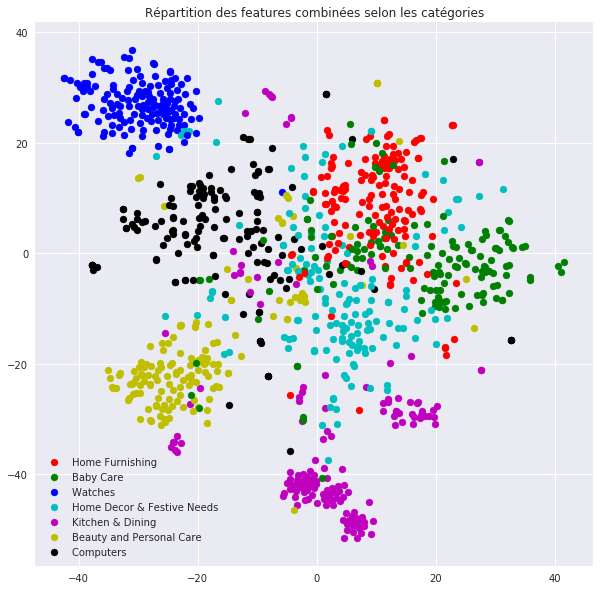

In [0]:
def dimension_reduction(values):
    for i in range(0, (len(values)+1)):
        svd = TruncatedSVD(n_components=i)
        svd.fit(values)
        if (svd.explained_variance_ratio_.sum() >= 0.80):
            nb_dim = i
            break
    svd = TruncatedSVD(n_components=nb_dim)
    values_projected = svd.fit_transform(values)
    return (values_projected)


def plot_cat(data, X, titre):
    sns.set()
    fig, ax = plt.subplots(figsize=(10, 10))
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    legend = {}
    i = 0
    for c in data.unique():
        legend[c] = colors[i]
        i = i+1
    for i, name in zip(range(len(list(data))), list(data)):
        plt.scatter(X[i, 0], X[i, 1], c=legend[data.at[i]], label=name)
    handles, labels = ax.get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(handles, labels):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    plt.legend(handle_list, label_list)
    plt.title(titre)
    plt.show()

values_projected = dimension_reduction(features_tot)
X_embedded = tsne.fit_transform(values_projected)
y = list(data['product_category_tree'])

for c in data['product_category_tree'].unique():
    print ("Catégorie", c, " : ", y.count(c))

plot_cat(data['product_category_tree'], X_embedded,
         "Répartition des features combinées selon les catégories")


For n_clusters = 2 The average silhouette_score is : 0.0030119102998976788
For n_clusters = 3 The average silhouette_score is : 0.022867659686968904
For n_clusters = 4 The average silhouette_score is : 0.042815211070664334
For n_clusters = 5 The average silhouette_score is : 0.04801921282840997
For n_clusters = 6 The average silhouette_score is : 0.05943296127351724
For n_clusters = 7 The average silhouette_score is : 0.06419183312584265
For n_clusters = 8 The average silhouette_score is : 0.0689490483269096
For n_clusters = 9 The average silhouette_score is : 0.07372279526787888


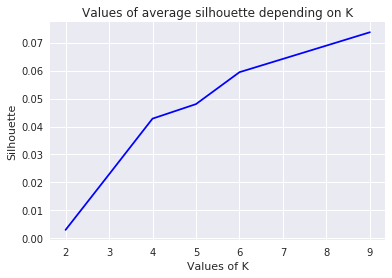

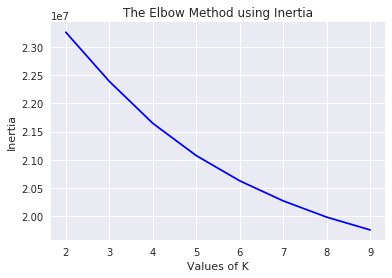

Nombre de clusters :  7
Nombre de variables :  1050
[1 3 3 ... 3 5 5]
Cluster 1  :  230
Cluster 3  :  148
Cluster 0  :  134
Cluster 5  :  198
Cluster 4  :  113
Cluster 2  :  79
Cluster 6  :  148


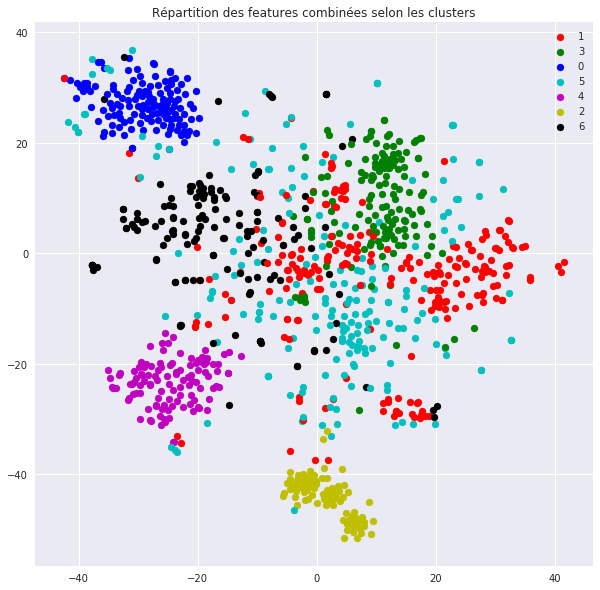

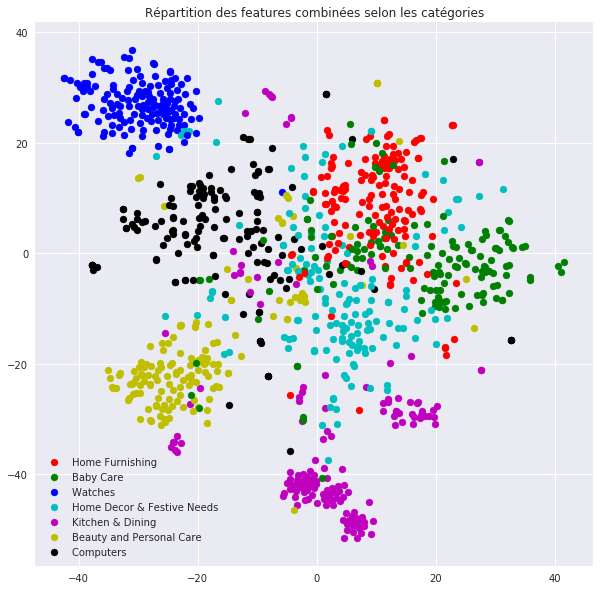

In [0]:
def kmeans(values):
    K = range(2, 10)
    distortions = []
    inertias = []
    silhouette = []
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=1)
        kmeanModel.fit(values)
        cluster_labels = kmeanModel.predict(values)
        inertias.append(kmeanModel.inertia_)
        silhouette_avg = metrics.silhouette_score(values, cluster_labels)
        silhouette.append(silhouette_avg)
        print("For n_clusters =", k, "The average silhouette_score is :",
              silhouette_avg)

    sns.set()
    plt.plot(K, silhouette, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Silhouette')
    plt.title('Values of average silhouette depending on K')
    plt.show()

    sns.set()
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method using Inertia')
    plt.show()


def kmeans7(values):
    kmeans = KMeans(n_clusters=7, random_state=1)
    kmeans.fit(values)
    y_kmeans = kmeans.predict(values)
    centers = kmeans.cluster_centers_
    columns = y

    print ("Nombre de clusters : ", len(centers))
    print ("Nombre de variables : ", len(y_kmeans))
    data['clusters_tot_kmeans'] = y_kmeans

    sns.set()
    clusterstotal = data.groupby(['clusters_tot_kmeans'])
    countclusterstotal = clusterstotal['clusters_tot_kmeans'].count()
    countclusterstotal = countclusterstotal.sort_values(ascending=False)
    labels = countclusterstotal.index
    sizes = countclusterstotal.values
    return(y_kmeans)

kmeans(values_projected)
y_kmeans = kmeans7(values_projected)
print (y_kmeans)

for c in data['clusters_tot_kmeans'].unique():
    print ("Cluster", c, " : ", list(y_kmeans).count(c))

plot_cat(data['clusters_tot_kmeans'], X_embedded,
         "Répartition des features combinées selon les clusters")
plot_cat(data['product_category_tree'], X_embedded,
         "Répartition des features combinées selon les catégories")
